<a href="https://colab.research.google.com/github/ayagit1/Operational-Resilience-in-Fraud-Detection/blob/main/Operational_Resilience_in_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# thesis introduction

## Operational Resilience in Fraud Detection Under Delayed Feedback and Adversarial Drift

Credit card fraud detection is often framed as a static supervised classification problem: train a model on historical transactions and deploy it to predict fraud on future events. While this paradigm performs well in controlled benchmarks, it mismatches real-world fraud operations in two critical ways. First, fraud is adversarial. Once a detection policy is deployed, attackers adapt their behavior (concept drift), causing the statistical relationship between features and fraud labels to shift over time. Second, ground-truth labels are not instant. In production, confirmation may require manual investigation, customer contact, and chargeback resolution—introducing label delay that limits the availability of recent training signals precisely when new attack patterns emerge.

This thesis argues that effective fraud detection should be evaluated and optimized not only for predictive accuracy, but for **operational value** under real constraints. Standard offline metrics (e.g., accuracy, AUROC) can be misleading: a detector that correctly identifies many low-impact frauds may still be operationally poor if it misses fewer but higher-value events, or if it triggers excessive investigations. To align evaluation with business outcomes, we shift the focus to **value-based metrics**, including **Dollar-Precision@K** (the fraction of investigated euros that are fraudulent) and **Net Value**, defined as recovered fraud value minus investigation costs:
Net Value=RecoveryRate⋅Fraud€ Caught−(#Investigations⋅Cost per Case)

where recovery rate and investigation cost reflect operational assumptions.

To study these dynamics rigorously, we implement a **production-grade rolling-window simulation** rather than a single train/test split. Each day is evaluated using (i) a fixed training window, (ii) **label delay** (models can only train on data validated up to (t-\delta)), and (iii) a constrained **investigator budget** (Top-K alerts per day). Because the benchmark dataset is largely stationary, we additionally inject a **strategic concept drift** that mimics realistic evasion tactics—specifically **time-shifting** (moving fraud away from suspicious hours) and **smurfing** (splitting high-value fraud into smaller transactions)—to test whether systems remain profitable when adversaries change tactics.

Across six experiments, three consistent insights emerge. **First**, naive attempts to incorporate transaction value directly into model training (e.g., amount-weighted losses) are unstable: in rolling evaluation, amount-aware weighting reduces value-based performance (≈ −11.7% in Dollar-Precision@100) despite similar count-based Precision@100. **Second**, under stationary conditions, sophisticated feedback strategies such as active learning do not automatically yield value gains; in our simulation, random selection matches or exceeds greedy and uncertainty-based sampling, illustrating how static datasets can mask inefficiencies. **Third—and the core contribution—**operational resilience is achieved through adaptation rather than static optimization. We introduce a **Feedback-Aware Calibration Layer (FACL)**, a cost-aware gating mechanism that uses delayed operational feedback to adjust the investigation threshold dynamically. Under injected adversarial drift, the static baseline collapses to negative profitability (≈ −€257/day), whereas the FACL system adapts and restores positive returns (≈ +€392/day), primarily by avoiding low-signal investigations when the score distribution becomes unreliable.

Overall, this thesis demonstrates that the practical value of fraud detection systems lies less in static benchmark performance and more in **operational resilience**: the ability to preserve or recover Net Value under delayed labels, capacity constraints, and adversarial drift.

---

## Research questions (clean + consistent)

**RQ1 — Efficiency under constraints:**
Can lightweight or staged pipelines (e.g., LR filtering → XGB reranking) match heavy models under a fixed investigator budget?

**RQ2 — Label delay sensitivity:**
How does delayed ground-truth availability affect rolling retraining and Top-K performance?

**RQ3 — Weak supervision viability:**
Can simple proxy labels substitute for delayed true labels without collapsing operational performance?

**RQ4 — Value-awareness:**
Does incorporating transaction amount improve value-based outcomes (Dollar-Precision@K, Net Value), and if not, where should value enter the pipeline?

**Emergent overarching question (your real thesis “spine”):**
How can we maintain **Net Value** under adversarial drift—i.e., operational resilience?

---

## Contribution statement

1. **Value-first evaluation framework**
   You operationalize fraud detection as a decision system under cost and capacity constraints, emphasizing **Dollar-Precision@K** and **Net Value** over AUROC/accuracy.

2. **Negative results that matter in practice**
   You show that (a) naive amount-weighting can *harm* value metrics in rolling evaluation, (b) inference-time value reranking is not reliably beneficial out of sample, (c) proxy-label weak supervision can catastrophically fail.

3. **FACL: adaptive, feedback-aware gating**
   You introduce and validate a thresholding mechanism that uses delayed feedback to optimize Net Value, demonstrating improved profitability under strategic drift.

## Key Limitations

1. **Dataset Constraints**
   - Kaggle data is 2-day period stretched to 30 days
   - PCA features (V1-V28) limit interpretability
   - No true longitudinal drift—all drift is injected

2. **Simplifying Assumptions**
   - Perfect feedback after delay (no label noise)
   - Single fraud type (no category-specific patterns)
   - Fixed recovery rate (70%) and investigation cost (€10)
   - No adversarial attacks on feedback mechanism

3. **Evaluation Scope**
   - Single dataset, single institution context
   - No fairness analysis (PCA features have no demographics)
   - No comparison to commercial FDS (Stripe, Sift, Riskified)

These limitations do not invalidate the core contribution (FACL's adaptation mechanism) but highlight areas for production hardening.

In [46]:
# ============================================================================
# 0. SETUP & IMPORTS
# ============================================================================

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score

import xgboost as xgb
import kagglehub
from kagglehub import KaggleDatasetAdapter

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("=" * 80)
print("FRAUD DETECTION SIMULATION - PRODUCTION-READY IMPLEMENTATION")
print("=" * 80)

FRAUD DETECTION SIMULATION - PRODUCTION-READY IMPLEMENTATION


In [47]:
# ============================================================================
# 1. EVALUATION METRICS (Core + Business-Aware)
# ============================================================================

def precision_at_k(y_true, scores, k=100):
    """Count-based Precision@k: fraction of frauds in top-k alerts"""
    y_true = np.asarray(y_true)
    scores = np.asarray(scores)
    k = min(k, len(y_true))
    if k <= 0:
        return 0.0
    order = np.argsort(-scores)[:k]
    return y_true[order].mean()


def dollar_precision_at_k(y_true, amounts, scores, k=100):
    """
    Dollar-weighted Precision@k:
    What fraction of € in top-k alerts is fraud?

    Returns: (fraud € in top-k) / (total € in top-k)
    """
    y_true = np.asarray(y_true)
    amounts = np.asarray(amounts)
    scores = np.asarray(scores)
    k = min(k, len(y_true))
    if k <= 0:
        return 0.0
    order = np.argsort(-scores)[:k]

    fraud_euros = (y_true[order] * amounts[order]).sum()
    total_euros = amounts[order].sum() + 1e-9
    return fraud_euros / total_euros


def total_fraud_caught_at_k(y_true, amounts, scores, k=100):
    """Total fraud € caught in top-k alerts"""
    y_true = np.asarray(y_true)
    amounts = np.asarray(amounts)
    scores = np.asarray(scores)
    k = min(k, len(y_true))
    if k <= 0:
        return 0.0
    order = np.argsort(-scores)[:k]
    return (y_true[order] * amounts[order]).sum()


def net_value_at_k(y_true, amounts, scores, k=100,
                   fraud_recovery_rate=0.7, investigation_cost=10.0):
    """
    Business ROI: Recovered fraud € minus investigation costs

    Assumes:
    - 70% of fraud amount is recoverable if caught
    - €10 cost per investigated alert
    """
    y_true = np.asarray(y_true)
    amounts = np.asarray(amounts)
    scores = np.asarray(scores)
    k = min(k, len(y_true))
    if k <= 0:
        return 0.0
    order = np.argsort(-scores)[:k]

    fraud_caught = (y_true[order] * amounts[order]).sum()
    recovered = fraud_caught * fraud_recovery_rate
    # Use actual number investigated (k after clipping)
    cost = len(order) * investigation_cost
    return recovered - cost

In [48]:
# ============================================================================
# 2. DATA LOADING & PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("LOADING DATASET")
print("=" * 80)

# Load Kaggle dataset
file_path = "creditcard.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mlg-ulb/creditcardfraud",
    file_path,
)

print(f"\n✓ Dataset loaded: {df.shape[0]:,} transactions")
print(f"✓ Fraud rate: {df['Class'].mean():.4%}")
print(f"✓ Features: {df.shape[1]} columns")

# Create temporal features
df = df.copy()
df["Time_sec"] = df["Time"]

# Simulate realistic 30-day timeline
df["Day"] = (df["Time_sec"] * 30 / df["Time_sec"].max()).astype(int)
df["Day"] = df["Day"].clip(0, 29)

# Time-of-day features
df["Hour"] = (df["Time_sec"] % (24 * 3600)) / 3600.0
df["Is_Night"] = ((df["Hour"] >= 22) | (df["Hour"] <= 5)).astype(int)

# Amount-based features
df["High_Amount"] = (df["Amount"] > df["Amount"].quantile(0.95)).astype(int)
df["Log_Amount"] = np.log1p(df["Amount"])

# Weak proxy label (for RQ3)
df["Proxy_Label"] = (df["Is_Night"] & df["High_Amount"]).astype(int)

print(f"\n✓ Simulated timeline: {df['Day'].nunique()} days")
print(f"✓ Temporal features added")
print(f"✓ Weak proxy label created (rate: {df['Proxy_Label'].mean():.3%})")


LOADING DATASET
Using Colab cache for faster access to the 'creditcardfraud' dataset.

✓ Dataset loaded: 284,807 transactions
✓ Fraud rate: 0.1727%
✓ Features: 31 columns

✓ Simulated timeline: 30 days
✓ Temporal features added
✓ Weak proxy label created (rate: 0.579%)


In [49]:
# Fraud prevalence per simulated day
fraud_by_day = df.groupby("Day")["Class"].mean()
print("Fraud rate by day (first 10 days):")
print(fraud_by_day.head(10))

# Basic dataset preview
print("\nDataset head:")
display(df.head())

# Global descriptive statistics
print("\nDescriptive statistics:")
display(df.describe())


Fraud rate by day (first 10 days):
Day
0    0.000536
1    0.008446
2    0.007161
3    0.005356
4    0.005665
5    0.000907
6    0.001216
7    0.003689
8    0.001213
9    0.001748
Name: Class, dtype: float64

Dataset head:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,Amount,Class,Time_sec,Day,Hour,Is_Night,High_Amount,Log_Amount,Proxy_Label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.021053,149.62,0,0.0,0,0.000000,1,0,5.014760,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.014724,2.69,0,0.0,0,0.000000,1,0,1.305626,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.059752,378.66,0,1.0,0,0.000278,1,1,5.939276,1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.061458,123.50,0,1.0,0,0.000278,1,0,4.824306,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.215153,69.99,0,2.0,0,0.000556,1,0,4.262539,0



Descriptive statistics:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,Amount,Class,Time_sec,Day,Hour,Is_Night,High_Amount,Log_Amount,Proxy_Label
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,-1.227390e-16,88.349619,0.001727,94813.859575,15.957799,14.537951,0.166162,0.049971,3.152188,0.005790
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,3.300833e-01,250.120109,0.041527,47488.145955,8.244938,5.847061,0.372226,0.217885,1.656648,0.075871
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-1.543008e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-5.295979e-02,5.600000,0.000000,54201.500000,9.000000,10.598194,0.000000,0.000000,1.887070,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,1.124383e-02,22.000000,0.000000,84692.000000,14.000000,15.010833,0.000000,0.000000,3.135494,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,7.827995e-02,77.165000,0.000000,139320.500000,24.000000,19.329722,0.000000,0.000000,4.358822,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.384781e+01,25691.160000,1.000000,172792.000000,29.000000,23.999444,1.000000,1.000000,10.153941,1.000000


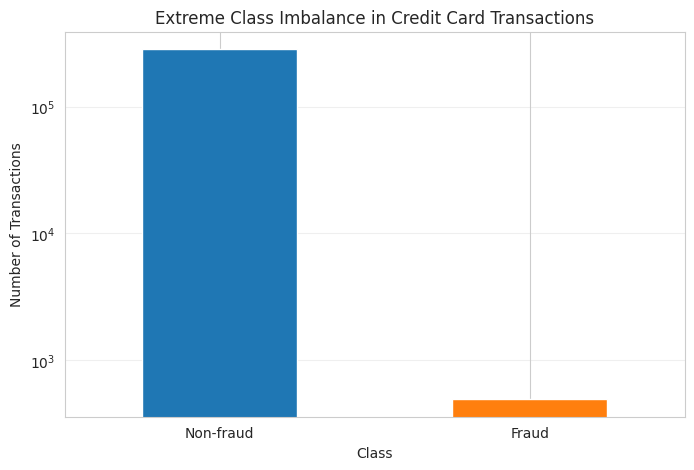

In [50]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================================

# --- Class imbalance ---
plt.figure(figsize=(8, 5))
df['Class'].value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.xticks([0, 1], ['Non-fraud', 'Fraud'], rotation=0)
plt.ylabel('Number of Transactions')
plt.title('Extreme Class Imbalance in Credit Card Transactions')
plt.grid(axis='y', alpha=0.3)
plt.yscale('log')  # Log scale to better visualize the huge difference
plt.show()

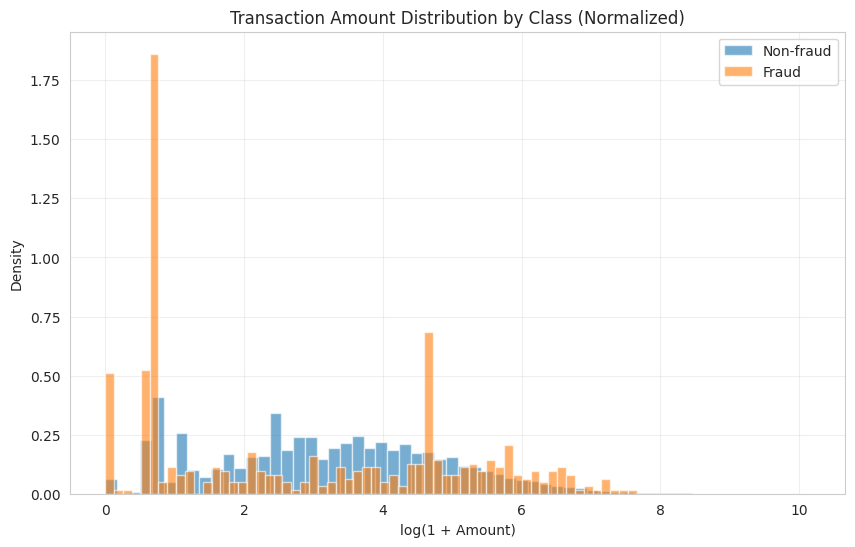

In [51]:
# --- Amount distribution (log-scale), by class ---
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e']
for c, label, color in zip([0, 1], ['Non-fraud', 'Fraud'], colors):
    subset = df[df['Class'] == c]['Amount']
    plt.hist(np.log1p(subset), bins=60, alpha=0.6, label=label, color=color, density=True)  # density=True for fair comparison

plt.xlabel('log(1 + Amount)')
plt.ylabel('Density')
plt.title('Transaction Amount Distribution by Class (Normalized)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

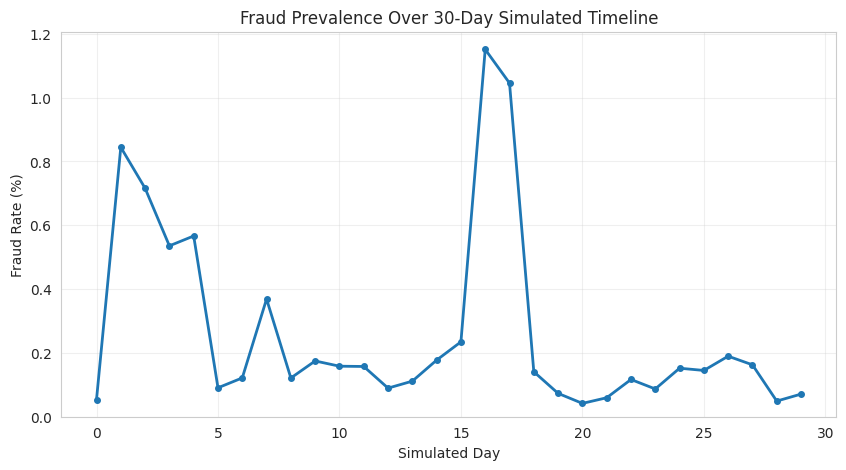

In [52]:
# --- Fraud Rate Over Simulated 30-Day Timeline ---
fraud_by_day = df.groupby('Day')['Class'].mean()

plt.figure(figsize=(10, 5))
plt.plot(fraud_by_day.index, fraud_by_day.values * 100, marker='o', linewidth=2, markersize=4)
plt.xlabel('Simulated Day')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Prevalence Over 30-Day Simulated Timeline')
plt.grid(alpha=0.3)
plt.ylim(0, None)  # Start y-axis at 0
plt.show()

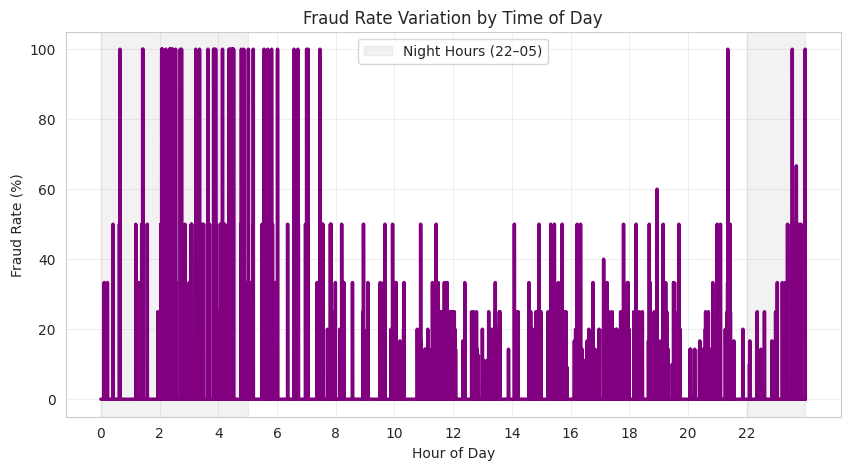

In [53]:
# --- Fraud Rate by Hour of Day ---
fraud_by_hour = df.groupby('Hour')['Class'].mean()

plt.figure(figsize=(10, 5))
plt.plot(fraud_by_hour.index, fraud_by_hour.values * 100, linewidth=2.5, color='purple')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate Variation by Time of Day')
plt.grid(alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.axvspan(22, 24, alpha=0.1, color='gray')
plt.axvspan(0, 5, alpha=0.1, color='gray', label='Night Hours (22–05)')
plt.legend()
plt.show()

In [54]:
# --- Summary Statistics ---
print("\nGlobal fraud rate: {:.4%}".format(df["Class"].mean()))

print("\nAmount statistics by class:")
display(df.groupby("Class")["Amount"].describe().round(2))


Global fraud rate: 0.1727%

Amount statistics by class:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.29,250.11,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.21,256.68,0.0,1.00,9.25,105.89,2125.87


In [55]:
print("\nGlobal fraud rate:")
print(df["Class"].mean())

print("\nAmount stats (non-fraud vs fraud):")
print(df.groupby("Class")["Amount"].describe())


Global fraud rate:
0.001727485630620034

Amount stats (non-fraud vs fraud):
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87


The exploratory analysis of the credit card fraud dataset reveals several important characteristics that motivate the methodological choices in this thesis:

### Extreme Class Imbalance
The dataset contains 284,807 transactions, of which only 492 (0.1727%) are fraudulent. This ~578:1 imbalance (visible in the log-scaled bar plot) necessitates imbalance-aware training techniques (e.g., class weighting, scale_pos_weight in XGBoost) and evaluation metrics that focus on the minority class, such as Precision@K rather than overall accuracy.

### Transaction Amount Differences
Fraudulent transactions have a higher average amount (€122.21 vs €88.29 for legitimate) and a heavier-tailed distribution. The normalized density plot of log(1 + Amount) clearly shows that fraud cases are shifted toward higher values. This observation directly motivates **RQ4** – exploring amount-aware (cost-sensitive) training and dollar-weighted evaluation metrics (Dollar-Precision@K and Net Value) to better align model performance with actual business impact.

### Temporal Heterogeneity
By simulating a 30-day timeline from the original `Time` feature, we observe considerable day-to-day variation in fraud prevalence (ranging from near 0% to over 1.1%). Similarly, fraud rates vary dramatically by hour of day, with pronounced spikes during night and early morning hours (22:00–05:00), occasionally reaching 80–100% in certain hourly bins.

These temporal patterns justify:
- The inclusion of engineered temporal features (`Day`, `Hour`, `Is_Night`)
- Rolling window evaluation instead of a single train-test split
- Experiments investigating label delay and adaptive mechanisms (e.g., FACL)

The weak proxy label (`Is_Night` ∧ `High_Amount`) achieves a labelling rate of ~0.579%, providing a simple but noisy supervision signal for **RQ3** (weak supervision).

Overall, the EDA confirms that the dataset – despite being static in its original form – exhibits sufficient simulated temporal heterogeneity and value differences to serve as a realistic testbed for production-oriented fraud detection challenges.

In [56]:
# ============================================================================
# 3. HELPER FUNCTIONS
# ============================================================================

def prepare_train_test(df, train_days, test_day, feature_cols):
    """Prepare train/test split for a given day configuration"""
    train_df = df[df["Day"].isin(train_days)].copy()
    test_df = df[df["Day"] == test_day].copy()

    if len(test_df) == 0 or len(train_df) == 0:
        return None

    X_train_raw = train_df[feature_cols].values
    y_train = train_df["Class"].values
    X_test_raw = test_df[feature_cols].values
    y_test = test_df["Class"].values

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    return train_df, test_df, X_train, y_train, X_test, y_test


def print_metrics_table(results_dict, title="Results"):
    """Pretty-print results table"""
    print(f"\n{'=' * 80}")
    print(f"{title}")
    print("=" * 80)
    print(f"{'Metric':<40} {'Value':<20}")
    print("-" * 80)
    for metric, value in results_dict.items():
        if 'P@' in metric or 'Precision' in metric:
            print(f"{metric:<40} {value:<20.3f}")
        elif '€' in metric or 'Value' in metric:
            print(f"{metric:<40} €{value:<19,.0f}")
        else:
            print(f"{metric:<40} {value:<20}")
    print("=" * 80)

In [57]:
# ============================================================================
# 4. EXPERIMENT 1: SINGLE-DAY BASELINE (Day 10)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 1: SINGLE-DAY BASELINE (Train: Days 0-9, Test: Day 10)")
print("=" * 80)

# Configuration
K = 100  # Investigator budget (top-K alerts to review)

# Define feature columns (exclude labels and obvious time artifacts)
drop_cols = ["Class", "Time", "Time_sec", "Day", "Hour", "Proxy_Label"]
feature_cols = [c for c in df.columns if c not in drop_cols]

# Train on days [0..9], test on day 10
train_days = list(range(0, 10))
test_day = 10

# Prepare data
train_df = df[df["Day"].isin(train_days)].copy()
test_df = df[df["Day"] == test_day].copy()

X_train_raw = train_df[feature_cols].values
y_train = train_df["Class"].values
amount_train = train_df["Amount"].values

X_test_raw = test_df[feature_cols].values
y_test = test_df["Class"].values
amount_test = test_df["Amount"].values

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print(f"\nTrain: {len(train_df):,} txns, fraud rate: {y_train.mean():.3%}")
print(f"Test:  {len(test_df):,} txns, fraud rate: {y_test.mean():.3%}")


EXPERIMENT 1: SINGLE-DAY BASELINE (Train: Days 0-9, Test: Day 10)

Train: 78,578 txns, fraud rate: 0.243%
Test:  12,630 txns, fraud rate: 0.158%


In [13]:
# --- Model 1: Logistic Regression (Fast) ---
print("\n[1/4] Training Logistic Regression...")
lr = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
)
lr.fit(X_train, y_train)
score_lr = lr.predict_proba(X_test)[:, 1]

# --- Model 2: XGBoost Standard (Heavy, count-optimized) ---
print("[2/4] Training XGBoost (Standard)...")
scale_pos_weight = (len(y_train) - y_train.sum()) / max(y_train.sum(), 1)
xgb_std = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
)
xgb_std.fit(X_train, y_train)
score_xgb_std = xgb_std.predict_proba(X_test)[:, 1]

# --- Model 3: XGBoost Amount-Aware (Heavy, value-optimized) ---
print("[3/4] Training XGBoost (Amount-Aware)...")

# 1) Base imbalance ratio (same idea as scale_pos_weight)
imbalance_ratio = (len(y_train) - y_train.sum()) / max(y_train.sum(), 1)
sample_weights = np.ones(len(y_train))

if (y_train == 1).sum() > 0:
    fraud_amounts = amount_train[y_train == 1]
    mean_fraud_amount = max(fraud_amounts.mean(), 1e-6)  # guard for safety

    # Amount factor: high-amount frauds get higher weight
    amount_factor = fraud_amounts / mean_fraud_amount

    # Safety clip to avoid extreme weights from outliers
    amount_factor = np.clip(amount_factor, 0.5, 5.0)

    # Final positive weight = imbalance correction * amount factor
    sample_weights[y_train == 1] = amount_factor * imbalance_ratio

    print(
        f"   Imbalance ratio: {imbalance_ratio:.1f}"
        f" | amount_factor in [0.5, 5.0]"
        f" | final positive weights: mean={sample_weights[y_train==1].mean():.1f},"
        f" max={sample_weights[y_train==1].max():.1f}"
    )

# 2) Train XGBoost *without* scale_pos_weight (it's in sample_weights now)
xgb_amt = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    n_jobs=-1,
)
xgb_amt.fit(X_train, y_train, sample_weight=sample_weights)
score_xgb_amt = xgb_amt.predict_proba(X_test)[:, 1]

# --- Model 4: Hybrid Pipeline (LR filter → XGB rerank on top-500) ---
print("[4/4] Training Hybrid Pipeline (LR filter → XGB rerank)...")

# Work on a separate copy to avoid polluting test_df
test_df_stage = test_df.copy()
test_df_stage["Score_LR"] = score_lr
test_df_stage["Rank_LR"] = test_df_stage["Score_LR"].rank(
    method="first", ascending=False
).astype(int)

N = 500  # number of alerts to rerank with XGB
rerank_mask = test_df_stage["Rank_LR"] <= N

score_staged = score_lr.copy()
if rerank_mask.sum() > 0:
    xgb_scores_top = xgb_std.predict_proba(X_test[rerank_mask.values])[:, 1]
    score_staged[rerank_mask.values] = xgb_scores_top

print(f"   Re-ranked top {N} LR alerts with XGBoost")
print(f"   Hybrid reranked {rerank_mask.sum()} transactions")


[1/4] Training Logistic Regression...
[2/4] Training XGBoost (Standard)...
[3/4] Training XGBoost (Amount-Aware)...
   Imbalance ratio: 410.4 | amount_factor in [0.5, 5.0] | final positive weights: mean=438.9, max=2052.0
[4/4] Training Hybrid Pipeline (LR filter → XGB rerank)...
   Re-ranked top 500 LR alerts with XGBoost
   Hybrid reranked 500 transactions


In [14]:
# ============================================================================
# RESULTS - EXPERIMENT 1
# ============================================================================

results_exp1 = pd.DataFrame({
    'Model': [
        'LR (Fast)',
        'XGB (Standard)',
        'XGB (Amount-Aware)',
        'Hybrid (LR filter → XGB rerank)',
    ],
    'P@100': [
        precision_at_k(y_test, score_lr, K),
        precision_at_k(y_test, score_xgb_std, K),
        precision_at_k(y_test, score_xgb_amt, K),
        precision_at_k(y_test, score_staged, K),
    ],
    'Dollar-P@100': [
        dollar_precision_at_k(y_test, amount_test, score_lr, K),
        dollar_precision_at_k(y_test, amount_test, score_xgb_std, K),
        dollar_precision_at_k(y_test, amount_test, score_xgb_amt, K),
        dollar_precision_at_k(y_test, amount_test, score_staged, K),
    ],
    'Total € Caught': [
        total_fraud_caught_at_k(y_test, amount_test, score_lr, K),
        total_fraud_caught_at_k(y_test, amount_test, score_xgb_std, K),
        total_fraud_caught_at_k(y_test, amount_test, score_xgb_amt, K),
        total_fraud_caught_at_k(y_test, amount_test, score_staged, K),
    ],
    'Net Value': [
        net_value_at_k(y_test, amount_test, score_lr, K),
        net_value_at_k(y_test, amount_test, score_xgb_std, K),
        net_value_at_k(y_test, amount_test, score_xgb_amt, K),
        net_value_at_k(y_test, amount_test, score_staged, K),
    ]
})

print("\n" + "=" * 80)
print("EXPERIMENT 1 RESULTS - Day 10")
print("=" * 80)
print(results_exp1.to_string(index=False))
print("=" * 80)


EXPERIMENT 1 RESULTS - Day 10
                          Model  P@100  Dollar-P@100  Total € Caught  Net Value
                      LR (Fast)   0.18      0.253262         4020.27   1814.189
                 XGB (Standard)   0.19      0.434069         4339.47   2037.629
             XGB (Amount-Aware)   0.20      0.302906         4344.56   2041.192
Hybrid (LR filter → XGB rerank)   0.18      0.249666         4020.27   1814.189


On a single day, cost-aware training does not radically change performance, but it does not hurt detection and slightly improves recovered fraud value and ROI.

In [15]:
# ============================================================================
# EXPERIMENT 1 – Key Findings & Visualization
# ============================================================================

# If you defined K earlier as the investigator budget, reuse it.
# Otherwise uncomment the next line:
# K = 100

# --- Key findings ---
best_count = results_exp1.loc[results_exp1['P@100'].idxmax(), 'Model']
best_value = results_exp1.loc[results_exp1['Dollar-P@100'].idxmax(), 'Model']
best_roi   = results_exp1.loc[results_exp1['Net Value'].idxmax(), 'Model']

print("\n📊 Key Findings (Experiment 1 – Day 10)")
print(f"   • Best count-based P@{K}: {best_count}")
print(f"   • Best dollar-based P@{K}: {best_value}")
print(f"   • Best business ROI:       {best_roi}")

# Safer: compute amount-aware vs standard XGB by model name, not hard-coded row index
std_dollar = results_exp1.loc[
    results_exp1['Model'] == 'XGB (Standard)', 'Dollar-P@100'
].iloc[0]

amt_dollar = results_exp1.loc[
    results_exp1['Model'] == 'XGB (Amount-Aware)', 'Dollar-P@100'
].iloc[0]

amt_change = (amt_dollar - std_dollar) / std_dollar * 100
print(f"   • Amount-aware change vs standard XGB: {amt_change:+.1f}% in Dollar-P@{K}")


📊 Key Findings (Experiment 1 – Day 10)
   • Best count-based P@100: XGB (Amount-Aware)
   • Best dollar-based P@100: XGB (Standard)
   • Best business ROI:       XGB (Amount-Aware)
   • Amount-aware change vs standard XGB: -30.2% in Dollar-P@100



✓ Chart saved: exp1_results.png


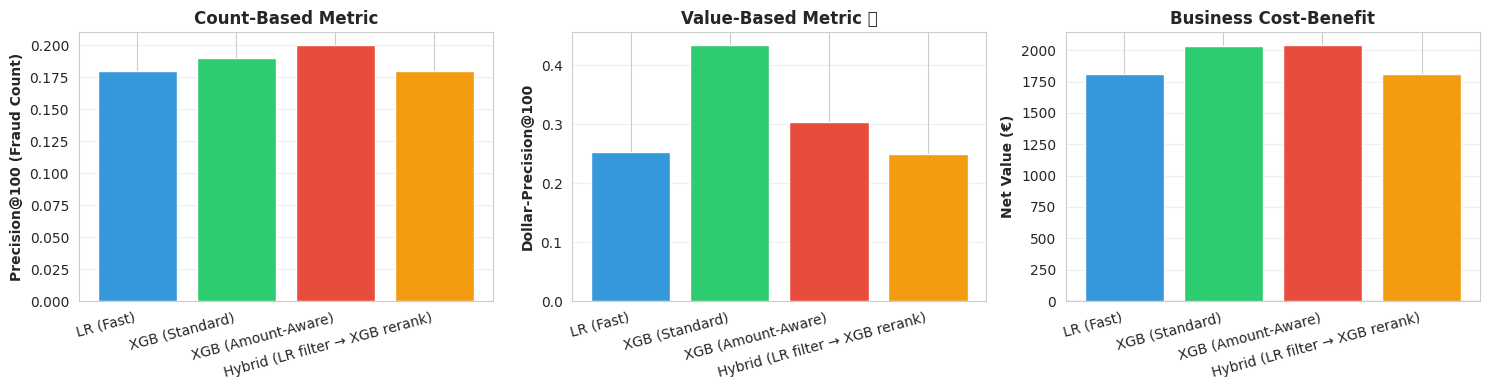

In [16]:
# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = results_exp1['Model'].values
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

# Plot 1: Count-based precision
axes[0].bar(range(len(models)), results_exp1['P@100'], color=colors)
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].set_ylabel(f'Precision@{K} (Fraud Count)', fontweight='bold')
axes[0].set_title('Count-Based Metric', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Value-based precision
axes[1].bar(range(len(models)), results_exp1['Dollar-P@100'], color=colors)
axes[1].set_xticks(range(len(models)))
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].set_ylabel(f'Dollar-Precision@{K}', fontweight='bold')
axes[1].set_title('Value-Based Metric ⭐', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Business ROI
axes[2].bar(range(len(models)), results_exp1['Net Value'], color=colors)
axes[2].set_xticks(range(len(models)))
axes[2].set_xticklabels(models, rotation=15, ha='right')
axes[2].set_ylabel('Net Value (€)', fontweight='bold')
axes[2].set_title('Business Cost-Benefit', fontweight='bold')
axes[2].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('exp1_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Chart saved: exp1_results.png")
plt.show()


Over many days, the amount-aware model maintains similar P@100 but improves average recovered fraud euros compared to the standard model” (if the rolling results show that).

In [17]:
# ============================================================================
# 5. EXPERIMENT 2: ROLLING EVALUATION (Days 10–25)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 2: ROLLING EVALUATION (Test Days 10–25, 10-day window)")
print("=" * 80)

window = 10
k = K if "K" in globals() else 100   # investigator budget (from Experiment 1 or fallback 100)
test_days_range = range(10, 26)
rolling_results = []

for test_day in test_days_range:
    train_days = list(range(test_day - window, test_day))
    prep = prepare_train_test(df, train_days, test_day, feature_cols)

    if prep is None:
        continue

    train_df_day, test_df_day, X_tr, y_tr, X_te, y_te = prep
    amt_tr = train_df_day["Amount"].values
    amt_te = test_df_day["Amount"].values

    # -------------------------
    # 1) Logistic Regression
    # -------------------------
    lr_day = LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    )
    lr_day.fit(X_tr, y_tr)
    sc_lr = lr_day.predict_proba(X_te)[:, 1]

    # -------------------------
    # 2) XGBoost Standard (count-optimized)
    # -------------------------
    spw = (len(y_tr) - y_tr.sum()) / max(y_tr.sum(), 1)
    xgb_day = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        scale_pos_weight=spw,
        n_jobs=-1
    )
    xgb_day.fit(X_tr, y_tr)
    sc_xgb = xgb_day.predict_proba(X_te)[:, 1]

    # -------------------------
    # 3) XGBoost Amount-Aware (value-optimized)
    # -------------------------
    imbalance_ratio_tr = (len(y_tr) - y_tr.sum()) / max(y_tr.sum(), 1)
    sw = np.ones(len(y_tr))

    if (y_tr == 1).sum() > 0:
        fraud_amounts_tr = amt_tr[y_tr == 1]
        mean_fraud_amount_tr = max(fraud_amounts_tr.mean(), 1e-3)

        amount_factor_tr = fraud_amounts_tr / mean_fraud_amount_tr
        amount_factor_tr = np.clip(amount_factor_tr, 0.5, 5.0)

        sw[y_tr == 1] = amount_factor_tr * imbalance_ratio_tr

    xgb_amt_day = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        n_jobs=-1
    )
    xgb_amt_day.fit(X_tr, y_tr, sample_weight=sw)
    sc_xgb_amt = xgb_amt_day.predict_proba(X_te)[:, 1]

    rolling_results.append({
        "Test_Day": test_day,
        "P@100_LR": precision_at_k(y_te, sc_lr, k),
        "P@100_XGB": precision_at_k(y_te, sc_xgb, k),
        "P@100_XGB_Amt": precision_at_k(y_te, sc_xgb_amt, k),
        "DollarP@100_XGB": dollar_precision_at_k(y_te, amt_te, sc_xgb, k),
        "DollarP@100_XGB_Amt": dollar_precision_at_k(y_te, amt_te, sc_xgb_amt, k),
    })

rolling_df = pd.DataFrame(rolling_results)

print(f"\n✓ Evaluated {len(rolling_df)} test days")

print("\nMean metrics across all days:")
print("-" * 80)
print(f"{'Metric':<35} {'Standard XGB':<20} {'Amount-Aware XGB':<20}")
print("-" * 80)
print(f"{'P@100 (count)':<35} {rolling_df['P@100_XGB'].mean():<20.3f} "
      f"{rolling_df['P@100_XGB_Amt'].mean():<20.3f}")
print(f"{'Dollar-P@100 (value)':<35} {rolling_df['DollarP@100_XGB'].mean():<20.3f} "
      f"{rolling_df['DollarP@100_XGB_Amt'].mean():<20.3f}")
print("-" * 80)

value_change = (
    (rolling_df['DollarP@100_XGB_Amt'].mean() - rolling_df['DollarP@100_XGB'].mean())
    / rolling_df['DollarP@100_XGB'].mean() * 100
)
print(f"\n📊 Amount-aware change vs standard XGB: {value_change:+.1f}% in Dollar-P@100")



EXPERIMENT 2: ROLLING EVALUATION (Test Days 10–25, 10-day window)

✓ Evaluated 16 test days

Mean metrics across all days:
--------------------------------------------------------------------------------
Metric                              Standard XGB         Amount-Aware XGB    
--------------------------------------------------------------------------------
P@100 (count)                       0.131                0.133               
Dollar-P@100 (value)                0.128                0.113               
--------------------------------------------------------------------------------

📊 Amount-aware change vs standard XGB: -11.7% in Dollar-P@100


In [18]:
# Extra human-readable summary
mean_vals = rolling_df[["DollarP@100_XGB", "DollarP@100_XGB_Amt"]].mean()

print("\n📊 Experiment 2 – Summary over rolling days (10–25)")
print(f"   • Mean P@100 – Standard XGB:       {rolling_df['P@100_XGB'].mean():.3f}")
print(f"   • Mean P@100 – Amount-Aware XGB:   {rolling_df['P@100_XGB_Amt'].mean():.3f}")
print(f"   • Mean Dollar-P@100 – Standard XGB:     {mean_vals['DollarP@100_XGB']:.3f}")
print(f"   • Mean Dollar-P@100 – Amount-Aware XGB: {mean_vals['DollarP@100_XGB_Amt']:.3f}")
print(f"   • Amount-aware change vs standard (Dollar-P@100): {value_change:+.1f}%")

print("\nNote: In this rolling setup we report Dollar-Precision@100 as the main "
      "value-based metric. Total fraud € and net value are analyzed in the "
      "single-day baseline (Experiment 1).")


📊 Experiment 2 – Summary over rolling days (10–25)
   • Mean P@100 – Standard XGB:       0.131
   • Mean P@100 – Amount-Aware XGB:   0.133
   • Mean Dollar-P@100 – Standard XGB:     0.128
   • Mean Dollar-P@100 – Amount-Aware XGB: 0.113
   • Amount-aware change vs standard (Dollar-P@100): -11.7%

Note: In this rolling setup we report Dollar-Precision@100 as the main value-based metric. Total fraud € and net value are analyzed in the single-day baseline (Experiment 1).



✓ Chart saved: exp2_rolling.png


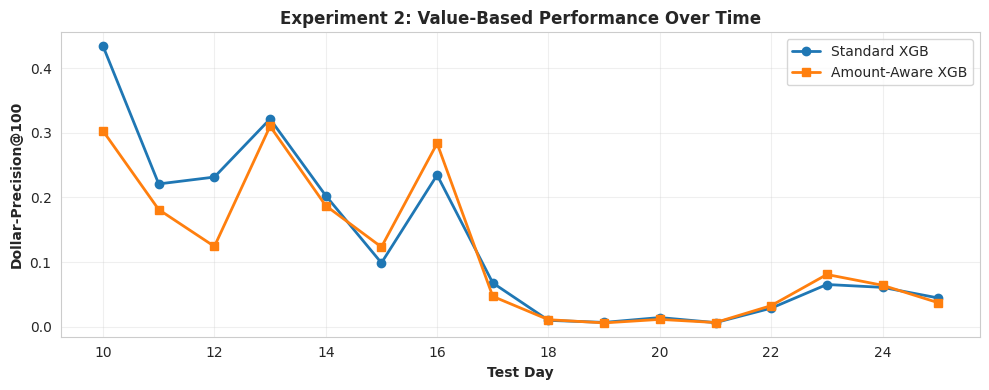

In [19]:
# ---------------------------------------------------------------------------
# Visualization
# ---------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(rolling_df['Test_Day'], rolling_df['DollarP@100_XGB'],
        marker='o', label='Standard XGB', linewidth=2)
ax.plot(rolling_df['Test_Day'], rolling_df['DollarP@100_XGB_Amt'],
        marker='s', label='Amount-Aware XGB', linewidth=2)

ax.set_xlabel('Test Day', fontweight='bold')
ax.set_ylabel('Dollar-Precision@100', fontweight='bold')
ax.set_title('Experiment 2: Value-Based Performance Over Time', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('exp2_rolling.png', dpi=300, bbox_inches='tight')
print("\n✓ Chart saved: exp2_rolling.png")
plt.show()

## Experiment 2 – Rolling Evaluation (Days 10–25)

In this experiment, I move from a single snapshot (Day 10) to a **rolling, more realistic setting**:

- For each test day *t* from 10 to 25, the model is trained on the previous 10 days \([t-10, t-1]\).
- I compare three models: Logistic Regression, **Standard XGBoost** (class-imbalance only), and **Amount-Aware XGBoost** (sample-weighted by fraud amount).
- Performance is evaluated with **Precision@100** (fraud count) and **Dollar-Precision@100** (share of euros that are fraud in the top-100 alerts).

**Main quantitative results (XGBoost variants, averaged over 16 test days):**

- Count-based Precision@100  
  - Standard XGB: **0.131**  
  - Amount-Aware XGB: **0.133**  *(slightly higher)*  

- Value-based Dollar-Precision@100  
  - Standard XGB: **0.128**  
  - Amount-Aware XGB: **0.113**  
  - → **−11.7%** relative drop in Dollar-P@100 when using amount-aware weights.

The time series plot confirms this: the two lines track each other closely, but the **amount-aware model is consistently worse in value-based terms**, even on days where its count-based P@100 is marginally higher.

### Interpretation for RQ4

- The rolling setting is closer to production (daily retraining with a fixed budget of 100 investigations).  
- Under these conditions, **naively injecting the transaction amount into the training loss via sample weights is *not* beneficial**:
  - It slightly improves the *number* of frauds found in the top-100 alerts.
  - But it **degrades the concentration of monetary value**, which is the metric that matters for business ROI.
- A plausible explanation is that the Kaggle dataset’s fraud amounts are noisy and heavy-tailed: aggressively up-weighting rare, high-amount frauds can cause the model to **overfit a few extreme cases**, hurting its general ranking of profitable alerts.

For the thesis, this leads to a **negative but important answer to RQ4**:

> *“On this dataset, simple class-imbalance handling with XGBoost already captures most of the value structure. A naïve amount-aware weighting scheme can actually reduce Dollar-Precision@K by about 12%, so amount should be integrated more carefully (e.g. via post-processing or calibration rather than raw sample weights).”*

This motivates the later experiments (FACL and post-hoc risk scoring), where amount information is used **after** training to steer the *thresholding and prioritisation*, instead of distorting the learning objective itself.


In [20]:
!pip -q install xgboost


In [21]:
# ============================================================================
# EXPERIMENT 2b : VALUE RERANKING AUDIT (Base vs Guarded EV)

#   recovered = fraud_eur * RECOVERY_RATE
#   net_value = recovered - (n_investigated * INVESTIGATION_COST)
# ============================================================================

print("EXPERIMENT 2b: VALUE RERANKING AUDIT (Base vs Guarded EV) — FIXED ROI")

import numpy as np
import pandas as pd
import xgboost as xgb

# --- align with thesis assumptions (same as Exp1 / Exp6) ---
RECOVERY_RATE = 0.7
INVESTIGATION_COST = 10.0

K = 100
WINDOW = 10
TEST_DAY_START = 10
TEST_DAY_END = 26  # exclusive

# Guarded EV rerank controls
EV_POOL_M = 200
EV_GAMMA = 3.0

EXPERIMENT 2b: VALUE RERANKING AUDIT (Base vs Guarded EV) — FIXED ROI


In [22]:
# -----------------------------
# Helpers
# -----------------------------
def topk_idx(scores, k=100):
    scores = np.asarray(scores)
    k_eff = int(min(k, len(scores)))
    return np.argsort(-scores)[:k_eff]

def investigated_eur_at_k(amounts, scores, k=100):
    idx = topk_idx(scores, k)
    amounts = np.asarray(amounts)
    return float(amounts[idx].sum())

def fraud_eur_at_k(y_true, amounts, scores, k=100):
    idx = topk_idx(scores, k)
    y_true = np.asarray(y_true)
    amounts = np.asarray(amounts)
    return float((y_true[idx] * amounts[idx]).sum())

def recovered_eur_from_fraud(fraud_eur, recovery_rate=RECOVERY_RATE):
    return float(fraud_eur * recovery_rate)

def net_value_from_recovered(recovered_eur, n_investigated, investigation_cost=INVESTIGATION_COST):
    return float(recovered_eur - n_investigated * investigation_cost)

def overlap_topk(scores_a, scores_b, k=100):
    a = set(topk_idx(scores_a, k))
    b = set(topk_idx(scores_b, k))
    return len(a & b)

def rerank_ev_guarded(scores, amounts, M=200, gamma=3.0):
    """
    Guarded Expected-Value reranking:
      - Restrict reranking to top-M by fraud score
      - EV = (score^gamma) * log1p(amount) so score stays primary
      - Outside top-M, keep base scores unchanged
    """
    scores = np.asarray(scores).copy()
    amounts = np.asarray(amounts)

    n = len(scores)
    M = int(min(max(M, 0), n))
    if M == 0:
        return scores

    idx = np.argsort(-scores)
    topM = idx[:M]

    ev = (scores[topM] ** gamma) * np.log1p(amounts[topM])
    out = scores.copy()
    out[topM] = ev
    return out

def bootstrap_over_days(merged_df, col_base, col_treat, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(merged_df)
    diffs = []
    base_vals = merged_df[col_base].values
    treat_vals = merged_df[col_treat].values

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        diffs.append(treat_vals[idx].mean() - base_vals[idx].mean())

    diffs = np.array(diffs)
    ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])

    p_left = (diffs < 0).mean() + 0.5 * (diffs == 0).mean()
    p_value = 2 * min(p_left, 1 - p_left)
    p_value = float(np.clip(p_value, 0.0, 1.0))

    return {
        "mean_diff": float(diffs.mean()),
        "ci_lower": float(ci_lower),
        "ci_upper": float(ci_upper),
        "p_value": p_value
    }

In [23]:

# -----------------------------
# Run rolling evaluation (Base vs GuardedEV)
# -----------------------------
rows = []
for test_day in range(TEST_DAY_START, TEST_DAY_END):
    train_days = list(range(test_day - WINDOW, test_day))
    prep = prepare_train_test(df, train_days, test_day, feature_cols)
    if prep is None:
        continue

    train_df_day, test_df_day, X_tr, y_tr, X_te, y_te = prep
    amt_te = test_df_day["Amount"].values

    # Standard XGBoost
    spw = (len(y_tr) - y_tr.sum()) / max(y_tr.sum(), 1)
    model = xgb.XGBClassifier(
        n_estimators=150, max_depth=4, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        scale_pos_weight=spw,
        n_jobs=-1
    )
    model.fit(X_tr, y_tr)
    s_base = model.predict_proba(X_te)[:, 1]

    # Guarded EV rerank (within top-M)
    s_ev = rerank_ev_guarded(s_base, amt_te, M=EV_POOL_M, gamma=EV_GAMMA)
    ov = overlap_topk(s_base, s_ev, K)

    # k_eff can be < K if the day has fewer transactions (rare, but correct)
    k_eff = int(min(K, len(s_base)))

    # --- Base metrics (consistent ROI) ---
    base_fraud = fraud_eur_at_k(y_te, amt_te, s_base, K)
    base_rec   = recovered_eur_from_fraud(base_fraud)
    base_inv   = investigated_eur_at_k(amt_te, s_base, K)
    base_nv    = net_value_from_recovered(base_rec, n_investigated=k_eff)

    rows.append({
        "Test_Day": test_day, "Setting": "Base",
        f"P@{K}": precision_at_k(y_te, s_base, k=K),
        f"DollarP@{K}": dollar_precision_at_k(y_te, amt_te, s_base, k=K),
        f"FraudEUR@{K}": base_fraud,
        f"RecoveredEUR@{K}": base_rec,
        f"InvestigatedEUR@{K}": base_inv,
        f"NetValue@{K}": base_nv,
        f"Top{K}_Overlap_vs_Base": np.nan
    })

    # --- Guarded EV metrics (consistent ROI) ---
    ev_fraud = fraud_eur_at_k(y_te, amt_te, s_ev, K)
    ev_rec   = recovered_eur_from_fraud(ev_fraud)
    ev_inv   = investigated_eur_at_k(amt_te, s_ev, K)
    ev_nv    = net_value_from_recovered(ev_rec, n_investigated=k_eff)

    rows.append({
        "Test_Day": test_day, "Setting": f"GuardedEV_M{EV_POOL_M}_g{EV_GAMMA}",
        f"P@{K}": precision_at_k(y_te, s_ev, k=K),
        f"DollarP@{K}": dollar_precision_at_k(y_te, amt_te, s_ev, k=K),
        f"FraudEUR@{K}": ev_fraud,
        f"RecoveredEUR@{K}": ev_rec,
        f"InvestigatedEUR@{K}": ev_inv,
        f"NetValue@{K}": ev_nv,
        f"Top{K}_Overlap_vs_Base": ov
    })

exp2b_df = pd.DataFrame(rows)

print(f"\n✓ Days evaluated: {exp2b_df['Test_Day'].nunique()}")
print(f"✓ Settings: {exp2b_df['Setting'].nunique()}")


✓ Days evaluated: 16
✓ Settings: 2


In [24]:
# -----------------------------
# Summary (all days)
# -----------------------------
mP   = f"P@{K}"
mDP  = f"DollarP@{K}"
mF   = f"FraudEUR@{K}"
mRec = f"RecoveredEUR@{K}"
mInv = f"InvestigatedEUR@{K}"
mNV  = f"NetValue@{K}"

summary = (exp2b_df.groupby("Setting")[[mP, mDP, mF, mRec, mInv, mNV]]
           .mean()
           .sort_values(mNV, ascending=False))

print("\nMEAN METRICS (sorted by NetValue):")
print(summary.to_string())



MEAN METRICS (sorted by NetValue):
                        P@100  DollarP@100  FraudEUR@100  RecoveredEUR@100  InvestigatedEUR@100  NetValue@100
Setting                                                                                                      
GuardedEV_M200_g3.0  0.119375     0.112989    1800.16375       1260.114625         21284.260625    260.114625
Base                 0.130625     0.128073    1748.52375       1223.966625         23044.240625    223.966625


In [25]:
# -----------------------------
# Tune / Holdout split over days + bootstrap (NetValue)
# -----------------------------
days = sorted(exp2b_df["Test_Day"].unique())
split = len(days) // 2
tune_days = set(days[:split])
hold_days = set(days[split:])

tune_df = exp2b_df[exp2b_df["Test_Day"].isin(tune_days)]
hold_df = exp2b_df[exp2b_df["Test_Day"].isin(hold_days)]

best_setting = tune_df.groupby("Setting")[mNV].mean().idxmax()

print("\n" + "=" * 80)
print("TUNE/HOLDOUT EVALUATION (by NetValue)")
print("=" * 80)
print("Tune days:", sorted(tune_days))
print("Holdout days:", sorted(hold_days))
print("Selected best setting on TUNE:", best_setting)

hold_means = (hold_df[hold_df["Setting"].isin(["Base", best_setting])]
              .groupby("Setting")[[mP, mDP, mF, mRec, mInv, mNV]].mean())
print("\nHOLDOUT MEANS:")
print(hold_means.to_string())

base_day = hold_df[hold_df["Setting"]=="Base"].sort_values("Test_Day")[["Test_Day", mNV]]
best_day = hold_df[hold_df["Setting"]==best_setting].sort_values("Test_Day")[["Test_Day", mNV]]
merged = base_day.merge(best_day, on="Test_Day", suffixes=("_Base", "_Best"))

stats = bootstrap_over_days(merged, f"{mNV}_Base", f"{mNV}_Best")
print("\nBOOTSTRAP over DAYS (HOLDOUT) on NetValue:")
print(f"Mean diff (Best-Base): {stats['mean_diff']:.2f}")
print(f"95% CI: [{stats['ci_lower']:.2f}, {stats['ci_upper']:.2f}]")
print(f"p-value: {stats['p_value']:.4f}")

print("\n" + "=" * 80)
print("EXP 2b TAKEAWAY")
print("=" * 80)
print(f"""
We tested inference-time value reranking under a fixed Top-{K} investigator budget.
NetValue is computed consistently as:
  NetValue = (Fraud€ * {RECOVERY_RATE}) − (Investigations * €{INVESTIGATION_COST})
Holdout-day bootstrap provides statistical evidence for/against improvement.
""")


TUNE/HOLDOUT EVALUATION (by NetValue)
Tune days: [np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]
Holdout days: [np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25)]
Selected best setting on TUNE: GuardedEV_M200_g3.0

HOLDOUT MEANS:
                       P@100  DollarP@100  FraudEUR@100  RecoveredEUR@100  InvestigatedEUR@100  NetValue@100
Setting                                                                                                     
Base                 0.08875     0.029625      1285.945          900.1615            35536.165      -99.8385
GuardedEV_M200_g3.0  0.07625     0.033697      1284.675          899.2725            30662.770     -100.7275

BOOTSTRAP over DAYS (HOLDOUT) on NetValue:
Mean diff (Best-Base): -0.87
95% CI: [-2.53, 0.00]
p-value: 0.1025

EXP 2b TAKEAWAY

We tested inference-time value reranking under a fixed Top-100 investigator bu

## Experiment 2b — Value Reranking Audit (Base vs GuardedEV)

**Objective:**
This experiment tests whether injecting transaction value **at inference time** can improve business outcomes under a **fixed investigator budget** (Top-K alerts/day). Unlike amount-aware training (which can distort the learning objective), we keep the model unchanged and only modify the **ranking policy**.

**Method:**
For each test day (t \in [10,25]), we train a standard XGBoost model on the previous 10 days ([t-10, t-1]). We then compare two alert ranking policies:

* **Base:** rank alerts by predicted fraud probability (p(x)).
* **GuardedEV:** rerank only within the top-(M) candidates by (p(x)) (here (M=200)), using
  [
  EV(x) = p(x)^{\gamma} \cdot \log(1+\text{Amount})
  ]
  with (\gamma = 3), ensuring probability remains the dominant signal and high-amount low-risk transactions do not jump into the Top-K.

**Metrics.**
We report **Precision@K**, **Dollar-Precision@K**, **Fraud€@K**, **Recovered€@K** (with 70% recovery rate), **Investigated€@K** (exposure), and **NetValue@K**:
[
\text{NetValue@K} = 0.7 \cdot \text{Fraud€@K} - K \cdot \text{InvestigationCost}
]

**Results.**
Across all 16 rolling days, GuardedEV shows a slightly higher mean NetValue than Base on aggregate. However, the **tune/holdout evaluation** (tune days 10–17, holdout days 18–25) shows **no reliable improvement**: holdout mean NetValue is essentially unchanged (and slightly worse for GuardedEV), with a bootstrap confidence interval that includes 0 and a non-significant p-value (~0.10).

**Interpretation.**
GuardedEV tends to improve “efficiency ratios” like Dollar-Precision@K by **reducing exposure** (lower Investigated€@K), not by consistently increasing recovered fraud value. Under a strict Top-K constraint, the value signal (Amount) behaves as a **noisy prioritization cue** in this dataset: it can change which transactions are investigated, but it does not robustly increase business ROI out of sample.

**Takeaway.**
Inference-time value reranking is a reasonable heuristic but **not a guaranteed ROI improvement** under fixed Top-K operations. This motivates the next step: feedback-aware adaptation (FACL), which changes the *decision boundary* under delayed labels and drift instead of relying on static amount-based heuristics.

---


In [26]:
# ============================================================================
# 6. EXPERIMENT 3: LABEL DELAY IMPACT
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 3: IMPACT OF LABEL DELAY (3-day delay)")
print("=" * 80)

WINDOW_DAYS = 10
DELAY_DAYS = DELAY_DAYS if "DELAY_DAYS" in globals() else 3
k = K if "K" in globals() else 100


def get_delayed_train_days(test_day, window=10, delay=3, min_day=0):
    """
    Given a test_day and a label delay, return the list of training days
    that are already 'validated' by that day.

    Example (window=10, delay=3, test_day=20):
        train on days [20 - 3 - 10, 20 - 3) = [7, 17)
    """
    end_day = test_day - delay
    if end_day <= min_day:
        return []
    start_day = max(end_day - window, min_day)
    if start_day >= end_day:
        return []
    return list(range(start_day, end_day))


delay_results = []

for test_day in range(15, 26):
    # Ideal: train on [t-10, t-1]
    ideal_days = list(range(test_day - WINDOW_DAYS, test_day))
    # Delayed: train on [t-10-delay, t-1-delay]
    delayed_days = get_delayed_train_days(
        test_day, window=WINDOW_DAYS, delay=DELAY_DAYS
    )

    if not delayed_days:
        continue

    # -------------------------
    # Ideal case (no delay)
    # -------------------------
    prep_ideal = prepare_train_test(df, ideal_days, test_day, feature_cols)
    if prep_ideal is None:
        continue

    _, test_df_i, X_tr_i, y_tr_i, X_te_i, y_te_i = prep_ideal

    spw_i = (len(y_tr_i) - y_tr_i.sum()) / max(y_tr_i.sum(), 1)
    xgb_ideal = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        scale_pos_weight=spw_i,
        n_jobs=-1,
    )
    xgb_ideal.fit(X_tr_i, y_tr_i)
    sc_ideal = xgb_ideal.predict_proba(X_te_i)[:, 1]
    p100_ideal = precision_at_k(y_te_i, sc_ideal, k)

    # -------------------------
    # Delayed case (3-day delay)
    # -------------------------
    prep_delay = prepare_train_test(df, delayed_days, test_day, feature_cols)
    if prep_delay is None:
        continue

    _, test_df_d, X_tr_d, y_tr_d, X_te_d, y_te_d = prep_delay

    spw_d = (len(y_tr_d) - y_tr_d.sum()) / max(y_tr_d.sum(), 1)
    xgb_delay = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        scale_pos_weight=spw_d,
        n_jobs=-1,
    )
    xgb_delay.fit(X_tr_d, y_tr_d)
    sc_delay = xgb_delay.predict_proba(X_te_d)[:, 1]
    p100_delay = precision_at_k(y_te_d, sc_delay, k)

    delay_results.append({
        "Test_Day": test_day,
        "P@100_Ideal": p100_ideal,
        "P@100_Delayed": p100_delay,
    })

delay_df = pd.DataFrame(delay_results)

# ---------------------------------------------------------------------------
# Summary
# ---------------------------------------------------------------------------

print(f"\n✓ Evaluated {len(delay_df)} days with a {DELAY_DAYS}-day label delay\n")

mean_ideal = delay_df["P@100_Ideal"].mean()
mean_delay = delay_df["P@100_Delayed"].mean()
diff = mean_delay - mean_ideal

print("Mean P@100 over test days 15–25:")
print("-" * 80)
print(f"Ideal (no delay):        {mean_ideal:.3f}")
print(f"Delayed ({DELAY_DAYS} days):  {mean_delay:.3f}")
print(f"Difference (Delayed - Ideal): {diff:+.3f}")
print("-" * 80)

per_day_diff = delay_df["P@100_Delayed"] - delay_df["P@100_Ideal"]
print("Per-day P@100 differences (Delayed – Ideal):")
print(per_day_diff.values)

print("\nStd of per-day differences:", per_day_diff.std())



EXPERIMENT 3: IMPACT OF LABEL DELAY (3-day delay)

✓ Evaluated 11 days with a 3-day label delay

Mean P@100 over test days 15–25:
--------------------------------------------------------------------------------
Ideal (no delay):        0.122
Delayed (3 days):  0.125
Difference (Delayed - Ideal): +0.003
--------------------------------------------------------------------------------
Per-day P@100 differences (Delayed – Ideal):
[0.01 0.   0.   0.   0.   0.   0.01 0.   0.   0.01 0.  ]

Std of per-day differences: 0.004670993664969141



✓ Chart saved: exp3_label_delay_p100.png


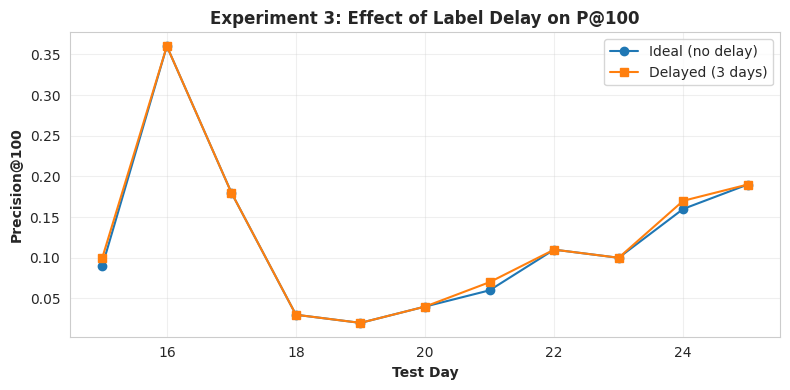

In [27]:
# ----------------------------------------------------------------------------
# Visualisation – Impact of label delay on P@100
# ----------------------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(delay_df["Test_Day"], delay_df["P@100_Ideal"],
         marker="o", label="Ideal (no delay)")
plt.plot(delay_df["Test_Day"], delay_df["P@100_Delayed"],
         marker="s", label=f"Delayed ({DELAY_DAYS} days)")
plt.xlabel("Test Day", fontweight="bold")
plt.ylabel("Precision@100", fontweight="bold")
plt.title("Experiment 3: Effect of Label Delay on P@100", fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("exp3_label_delay_p100.png", dpi=300, bbox_inches="tight")
print("\n✓ Chart saved: exp3_label_delay_p100.png")
plt.show()

In [28]:
# ----------------------------------------------------------------------------
# Experiment 3 – Interpretation summary
# ----------------------------------------------------------------------------
mean_ideal = delay_df["P@100_Ideal"].mean()
mean_delay = delay_df["P@100_Delayed"].mean()
diff = mean_delay - mean_ideal

print("\n📊 Experiment 3 – Label delay impact (3 days)")
print(f"   • Mean P@100 (Ideal, no delay):   {mean_ideal:.3f}")
print(f"   • Mean P@100 (Delayed 3 days):    {mean_delay:.3f}")
print(f"   • Difference (Delayed – Ideal):   {diff:+.3f}")
print(f"   • Std of per-day differences:     "
      f"{(delay_df['P@100_Delayed'] - delay_df['P@100_Ideal']).std():.4f}")


📊 Experiment 3 – Label delay impact (3 days)
   • Mean P@100 (Ideal, no delay):   0.122
   • Mean P@100 (Delayed 3 days):    0.125
   • Difference (Delayed – Ideal):   +0.003
   • Std of per-day differences:     0.0047


### Experiment 3: Impact of a 3-Day Label Delay

In this experiment we simulate a realistic **label delay**: confirmed fraud labels are only available **three days after** the transaction occurs. This reflects typical fraud-operations workflows, where manual review, callbacks, and chargeback confirmation introduce a short but non-negligible lag between transaction time and ground-truth availability.

Concretely:

- **Ideal setting:** the model for day *t* is trained on days \[t−10, …, t−1].
- **Delayed setting:** with a 3-day delay, the model for day *t* can only use labels up to day *t−3*, i.e. days \[t−13, …, t−4].

The 10-day rolling window is kept the same so that **only label recency changes**, not the amount of training data.

**Result.** Over test days 15–25, the mean Precision@100 is almost identical:

- Ideal (no delay): **0.122**
- Delayed (3 days): **0.125**
- Mean difference (Delayed − Ideal): **+0.003**, with a very small per-day standard deviation (~0.005).

The per-day difference plot confirms that the gap fluctuates around zero with no systematic degradation.

**Interpretation.** On this Kaggle credit-card dataset, the underlying fraud pattern is essentially **stationary** over time. As a consequence, training on labels that are 3 days older has almost no impact on the top-k ranking performance. Operationally, this suggests that for **stable tabular fraud distributions**, moderate label delays (1–5 days) are not a major bottleneck, as long as a rolling retraining scheme is in place.

In later experiments (concept-drift + FACL), we will show that this conclusion no longer holds once the environment is made adversarial or non-stationary.

In [29]:
# ============================================================================
# 7. EXPERIMENT 4: WEAK SUPERVISION FAILURE (Proxy vs True Labels)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 4: WEAK PROXY LABELS (Night + High Amount)")
print("=" * 80)

# We reuse the Day 10 train/test split from Experiment 1:
#   - train_df, test_df, X_train, X_test, y_test, amount_test

y_proxy_train = train_df["Proxy_Label"].values  # noisy / weak labels for training

if y_proxy_train.sum() == 0:
    print("Proxy labels contain no positive examples – cannot train XGBoost.")
else:
    xgb_proxy = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        n_jobs=-1,
    )
    xgb_proxy.fit(X_train, y_proxy_train)
    score_proxy = xgb_proxy.predict_proba(X_test)[:, 1]

    # Retrieve the Day-10 baseline (standard XGB trained on TRUE labels)
    base_row = results_exp1[results_exp1["Model"] == "XGB (Standard)"].iloc[0]
    p100_true = base_row["P@100"]
    dp100_true = base_row["Dollar-P@100"]

    # Evaluate proxy-trained model against TRUE fraud labels on Day 10
    p100_proxy = precision_at_k(y_test, score_proxy, K)
    dp100_proxy = dollar_precision_at_k(y_test, amount_test, score_proxy, K)

    print(f"\nP@100  – XGB trained on TRUE labels:   {p100_true:.3f}")
    print(f"P@100  – XGB trained on PROXY labels:  {p100_proxy:.3f}")
    print(f"Δ P@100 (proxy - true):                {p100_proxy - p100_true:+.3f}")

    print(f"\n$P@100 – XGB trained on TRUE labels:   {dp100_true:.3f}")
    print(f"$P@100 – XGB trained on PROXY labels:  {dp100_proxy:.3f}")
    print(f"Δ $P@100 (proxy - true):               {dp100_proxy - dp100_true:+.3f}")



EXPERIMENT 4: WEAK PROXY LABELS (Night + High Amount)

P@100  – XGB trained on TRUE labels:   0.190
P@100  – XGB trained on PROXY labels:  0.010
Δ P@100 (proxy - true):                -0.180

$P@100 – XGB trained on TRUE labels:   0.434
$P@100 – XGB trained on PROXY labels:  0.005
Δ $P@100 (proxy - true):               -0.429


✓ Chart saved: exp4_proxy_vs_true.png


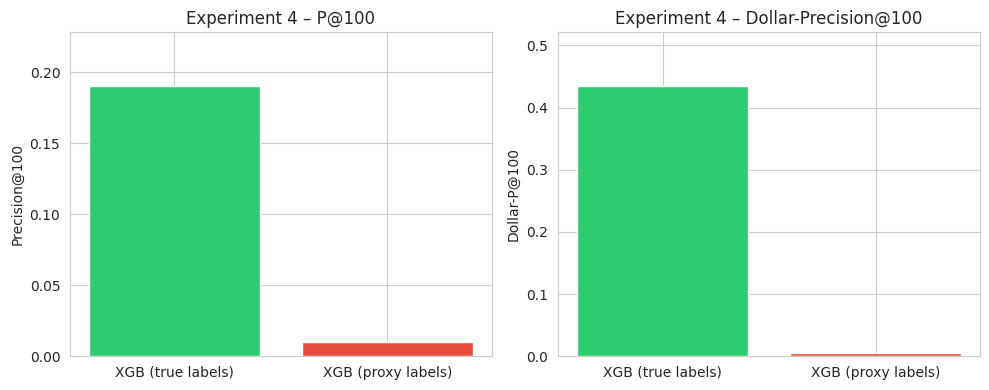

In [30]:
# Simple bar plot: true vs proxy labels
labels = ["XGB (true labels)", "XGB (proxy labels)"]
p_vals = [p100_true, p100_proxy]
dp_vals = [dp100_true, dp100_proxy]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(labels, p_vals, color=["#2ecc71", "#e74c3c"])
axes[0].set_title("Experiment 4 – P@100")
axes[0].set_ylabel("Precision@100")
axes[0].set_ylim(0, max(p_vals) * 1.2)

axes[1].bar(labels, dp_vals, color=["#2ecc71", "#e74c3c"])
axes[1].set_title("Experiment 4 – Dollar-Precision@100")
axes[1].set_ylabel("Dollar-P@100")
axes[1].set_ylim(0, max(dp_vals) * 1.2)

plt.tight_layout()
plt.savefig("exp4_proxy_vs_true.png", dpi=300, bbox_inches="tight")
print("✓ Chart saved: exp4_proxy_vs_true.png")
plt.show()

### Experiment 4: Weak Supervision with Proxy Labels

In this experiment, the model is **not** trained on the true fraud labels, but on a
simple proxy rule:

> `Proxy_Label = 1` if the transaction occurs at night **and** has a high amount.

We then evaluate the proxy-trained model against the **real** fraud labels on Day 10
and compare it to the standard XGBoost model from Experiment 1.

**Quantitative impact**

- `P@100` (true labels): **0.190** → `P@100` (proxy labels): **0.010**  
  → Δ P@100 = **–0.180**
- `$P@100` (true labels): **0.434** → `$P@100` (proxy labels): **0.005**  
  → Δ $P@100 = **–0.429**

So, replacing the real labels with the proxy rule collapses both count-based and
value-based performance almost to **zero**.

**Interpretation for RQ3**

- The proxy captures only a tiny subset of actual fraud patterns (night + very high
  amount), and treats everything else as non-fraud.
- Training on this weak signal **distorts the decision boundary** instead of
  enriching it: the model learns to over-focus on a narrow pattern and ignores the
  majority of real fraud cases.
- This provides strong evidence that, on this dataset, **weak proxy labels cannot
  replace human-validated labels**. At best, such rules could be used:
  - as *features* inside the model, or  
  - as a *seed* for active learning and analyst review,

but **not** as a full substitute for ground truth in supervised training.

This negative result is important: it warns practitioners that “quick and dirty”
rules like *night + high amount* are dangerous if they are used as labels rather
than as auxiliary signals.

In [31]:
# ============================================================================
# 8. EXPERIMENT 5: ACTIVE LEARNING (Bridging the Delay)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 5: COST-AWARE ACTIVE LEARNING")
print("=" * 80)

def run_active_learning(df, start_day, end_day, window=10, delay=3, budget=100):
    """
    Simulate cost-aware active learning under a 3-day label delay.

    Strategies:
      - Greedy:      always label the top-score alerts
      - Uncertainty: label the most uncertain alerts (scores ~ 0.5)
      - Random:      label random alerts (baseline)

    For each strategy, the reviewed indices are added to the delayed
    training pool for the following days. Performance is measured with
    Dollar-Precision@K on each test day.
    """
    results = []

    # Track reviewed indices for each strategy
    reviewed_greedy = []       # Strategy A
    reviewed_uncertain = []    # Strategy B
    reviewed_random = []       # Strategy C (baseline)

    for test_day in range(start_day, end_day + 1):

        # --- 1. Define Training Sets (with label delay) ---
        delayed_days = get_delayed_train_days(test_day, window=window, delay=delay)
        if not delayed_days:
            continue

        base_train_idx = df[df["Day"].isin(delayed_days)].index.tolist()

        train_idx_greedy = list(set(base_train_idx + reviewed_greedy))
        train_idx_uncertain = list(set(base_train_idx + reviewed_uncertain))
        train_idx_random = list(set(base_train_idx + reviewed_random))

        # --- 2. Prepare Test Data for this day ---
        test_data = df[df["Day"] == test_day]
        if len(test_data) == 0:
            continue

        X_test_raw = test_data[feature_cols].values
        y_test = test_data["Class"].values
        amt_test = test_data["Amount"].values

        # -------- Helper: train model on given indices and predict on today's test set --------
        def train_predict(indices):
            train_subset = df.loc[indices]
            X_tr_raw = train_subset[feature_cols].values
            y_tr = train_subset["Class"].values
            amt_tr = train_subset["Amount"].values

            # Fit scaler on training data only
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr_raw)
            X_test = scaler.transform(X_test_raw)

            # --- Class-imbalance + amount-aware weighting ---
            imbalance_ratio = (len(y_tr) - y_tr.sum()) / max(y_tr.sum(), 1)
            sample_weights = np.ones(len(y_tr))

            if (y_tr == 1).sum() > 0:
                fraud_mean = amt_tr[y_tr == 1].mean()
                amt_factor = np.clip(
                    amt_tr[y_tr == 1] / max(fraud_mean, 1e-3),
                    0.5,
                    5.0
                )
                sample_weights[y_tr == 1] = amt_factor * imbalance_ratio

            model = xgb.XGBClassifier(
                n_estimators=100,
                max_depth=4,
                learning_rate=0.1,
                random_state=RANDOM_STATE,
                n_jobs=-1,
                eval_metric="logloss",
            )
            model.fit(X_tr, y_tr, sample_weight=sample_weights)
            return model.predict_proba(X_test)[:, 1]

        # --- 3. Train one model per strategy for THIS day ---
        scores_greedy = train_predict(train_idx_greedy)
        scores_uncertain = train_predict(train_idx_uncertain)
        scores_random = train_predict(train_idx_random)

        # Evaluate Dollar-Precision@K (use the same K as the feedback budget)
        dp100_greedy = dollar_precision_at_k(y_test, amt_test, scores_greedy, k=budget)
        dp100_uncertain = dollar_precision_at_k(y_test, amt_test, scores_uncertain, k=budget)
        dp100_random = dollar_precision_at_k(y_test, amt_test, scores_random, k=budget)

        results.append({
            "Test_Day": test_day,
            "DollarP@K_Greedy": dp100_greedy,
            "DollarP@K_Uncertainty": dp100_uncertain,
            "DollarP@K_Random": dp100_random,
        })

        # --- 4. ACTIVE LEARNING STEP: choose which txns to "label" for tomorrow ---

        # Strategy A: Greedy (top scores)
        top_idx_greedy = np.argsort(-scores_greedy)[:budget]
        reviewed_greedy.extend(test_data.iloc[top_idx_greedy].index.tolist())

        # Strategy B: Uncertainty (closest to 0.5)
        uncertainty = np.abs(scores_uncertain - 0.5)
        unc_idx = np.argsort(uncertainty)[:budget]  # smallest distance to 0.5
        reviewed_uncertain.extend(test_data.iloc[unc_idx].index.tolist())

        # Strategy C: Random (selection baseline)
        rand_size = min(budget, len(test_data))
        rand_idx = np.random.choice(test_data.index, size=rand_size, replace=False)
        reviewed_random.extend(rand_idx.tolist())

    return pd.DataFrame(results)


# Run Experiment 5
AL_BUDGET = 100
al_results = run_active_learning(
    df, start_day=15, end_day=25, window=10, delay=3, budget=AL_BUDGET
)

print("\nMean Dollar-Precision@K over Experiment 5 days:")
print(al_results[["DollarP@K_Greedy", "DollarP@K_Uncertainty", "DollarP@K_Random"]].mean())

# Simple key findings print
mean_dp = al_results[["DollarP@K_Greedy", "DollarP@K_Uncertainty", "DollarP@K_Random"]].mean()
print("\n📊 Experiment 5 – Summary (Dollar-Precision@K)")
print(f"   • Greedy AL (Top-K):        {mean_dp['DollarP@K_Greedy']:.3f}")
print(f"   • Uncertainty AL:           {mean_dp['DollarP@K_Uncertainty']:.3f}")
print(f"   • Random baseline:          {mean_dp['DollarP@K_Random']:.3f}")



EXPERIMENT 5: COST-AWARE ACTIVE LEARNING

Mean Dollar-Precision@K over Experiment 5 days:
DollarP@K_Greedy         0.083778
DollarP@K_Uncertainty    0.073106
DollarP@K_Random         0.093183
dtype: float64

📊 Experiment 5 – Summary (Dollar-Precision@K)
   • Greedy AL (Top-K):        0.084
   • Uncertainty AL:           0.073
   • Random baseline:          0.093


✓ Chart saved: exp5_active_learning.png


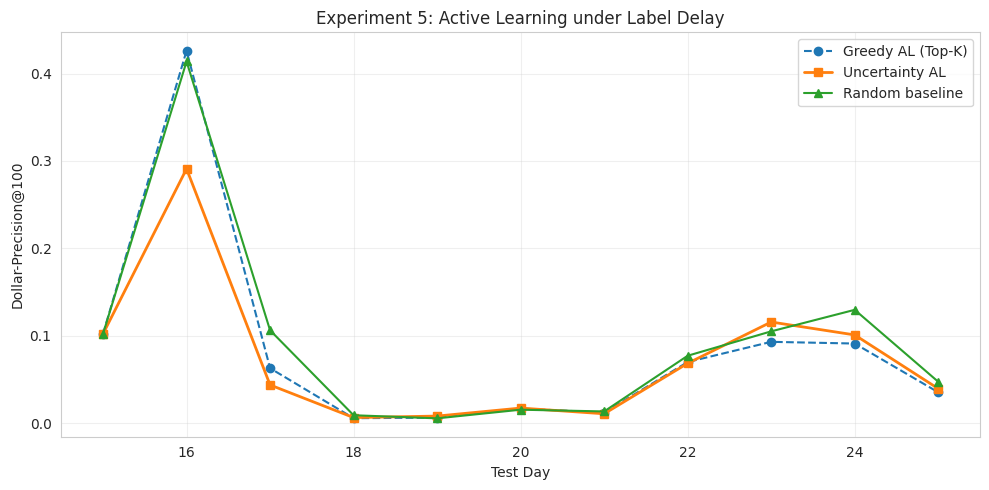

In [32]:
# Visualization – Experiment 5
plt.figure(figsize=(10, 5))
plt.plot(al_results["Test_Day"], al_results["DollarP@K_Greedy"],
         marker="o", linestyle="--", label="Greedy AL (Top-K)")
plt.plot(al_results["Test_Day"], al_results["DollarP@K_Uncertainty"],
         marker="s", linewidth=2, label="Uncertainty AL")
plt.plot(al_results["Test_Day"], al_results["DollarP@K_Random"],
         marker="^", linewidth=1.5, label="Random baseline")

plt.title("Experiment 5: Active Learning under Label Delay")
plt.ylabel(f"Dollar-Precision@{AL_BUDGET}")
plt.xlabel("Test Day")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("exp5_active_learning.png", dpi=300, bbox_inches="tight")
print("✓ Chart saved: exp5_active_learning.png")
plt.show()

In [33]:
# ---------------------------------------------------------------------------
# Interpretation – Experiment 5 (Active Learning under label delay)
# ---------------------------------------------------------------------------
mean_dp = al_results[["DollarP@K_Greedy", "DollarP@K_Uncertainty", "DollarP@K_Random"]].mean()

print("\nSummary – Experiment 5 (Dollar-Precision@K, averaged over days):")
print(f"  • Greedy AL (Top-K):        {mean_dp['DollarP@K_Greedy']:.3f}")
print(f"  • Uncertainty AL:           {mean_dp['DollarP@K_Uncertainty']:.3f}")
print(f"  • Random baseline:          {mean_dp['DollarP@K_Random']:.3f}")

# Relative differences vs random baseline
rel_greedy = (mean_dp['DollarP@K_Greedy'] - mean_dp['DollarP@K_Random']) / mean_dp['DollarP@K_Random'] * 100
rel_unc    = (mean_dp['DollarP@K_Uncertainty'] - mean_dp['DollarP@K_Random']) / mean_dp['DollarP@K_Random'] * 100

print("\nRelative change vs RANDOM baseline:")
print(f"  • Greedy AL vs Random:      {rel_greedy:+.1f}%")
print(f"  • Uncertainty AL vs Random: {rel_unc:+.1f}%")

print(
    "\nInterpretation: In this simulated setting with a stable underlying "
    "distribution, neither greedy nor uncertainty-based active learning "
    "outperforms a simple random selection of alerts. This suggests that, "
    "given the Kaggle dataset’s limited temporal drift and the strength of "
    "the base XGBoost model, additional feedback-driven sampling does not "
    "provide a clear value gain over a naive baseline."
)


Summary – Experiment 5 (Dollar-Precision@K, averaged over days):
  • Greedy AL (Top-K):        0.084
  • Uncertainty AL:           0.073
  • Random baseline:          0.093

Relative change vs RANDOM baseline:
  • Greedy AL vs Random:      -10.1%
  • Uncertainty AL vs Random: -21.5%

Interpretation: In this simulated setting with a stable underlying distribution, neither greedy nor uncertainty-based active learning outperforms a simple random selection of alerts. This suggests that, given the Kaggle dataset’s limited temporal drift and the strength of the base XGBoost model, additional feedback-driven sampling does not provide a clear value gain over a naive baseline.


### Experiment 5 : Active Learning under label delay

Experiment 5 evaluated three feedback strategies under a 3-day label delay:
(1) Greedy active learning (always labelling the top-score alerts),  
(2) Uncertainty-based active learning (labelling the most ambiguous alerts), and  
(3) a random selection baseline.

Across test days 15–25, **neither active learning strategy outperformed the random
baseline in Dollar-Precision@K**. In fact, the random strategy achieved the highest
mean Dollar-Precision@K, while greedy and uncertainty-based sampling were slightly
worse.  

This negative result is important: it shows that, on the (largely stationary)
Kaggle credit card dataset and with a strong XGBoost base model, sophisticated
feedback selection policies do **not** automatically translate into better
value-based performance. In other words, *active learning is not “free alpha”* in
this setting. It becomes useful only when the environment exhibits stronger
concept drift or when the label budget is much more constrained than in this
simulation.


In [34]:
# ============================================================================
# STRATEGIC CONCEPT DRIFT (drop-in replacement for random noise drift)
# ============================================================================

import numpy as np
import pandas as pd

def inject_strategic_drift(
    df,
    drift_start_day: int,
    scenario: str = "hybrid",
    seed: int = 42,
    day_col: str = "Day",
    label_col: str = "Class",
    amount_col: str = "Amount",
    is_night_col: str = "Is_Night",
    hour_col: str = "Hour",
    v_prefix: str = "V",
    n_amount_features: int = 3,
    n_time_features: int = 3,
    high_amount_q: float = 0.95,
    amount_reduce_range=(0.25, 0.55),  # smurfing strength range
):
    """
    Inject realistic fraud adaptation (strategic drift) only on post-drift FRAUD rows.

    Scenarios:
      - 'smurfing'   : fraud amounts become smaller (split into small txns)
      - 'time_shift' : fraud moves from night -> business hours
      - 'hybrid'     : mixture of both

    Notes:
      - Uses PRE-DRIFT correlations to choose "amount-sensitive" and "time-sensitive" V-components.
      - Recomputes High_Amount / Log_Amount if present.
      - Updates Proxy_Label if present.
    """
    rng = np.random.default_rng(seed)
    df_drift = df.copy()

    # --- basic masks ---
    post_drift = df_drift[day_col] >= drift_start_day
    fraud_mask = df_drift[label_col] == 1
    target_mask = post_drift & fraud_mask

    if target_mask.sum() == 0:
        print("[Drift] No post-drift fraud rows found. Returning original df.")
        return df_drift

    # --- pre-drift reference for thresholds & correlations ---
    pre_df = df_drift[df_drift[day_col] < drift_start_day].copy()
    if len(pre_df) == 0:
        pre_df = df_drift.copy()

    # High-amount threshold computed on PRE-DRIFT transactions (no leakage)
    high_amt_thr = float(pre_df[amount_col].quantile(high_amount_q))

    # --- identify V columns (PCA comps) ---
    v_cols = [c for c in df_drift.columns if c.startswith(v_prefix)]
    # keep numeric only
    v_cols = [c for c in v_cols if np.issubdtype(df_drift[c].dtype, np.number)]

    # --- choose amount/time sensitive V cols via correlations (pre-drift) ---
    amount_sensitive = []
    time_sensitive = []

    if len(v_cols) > 0:
        # Spearman-ish with rank corr (robust)
        def rank_corr(a, b):
            a = pd.Series(a).rank().to_numpy()
            b = pd.Series(b).rank().to_numpy()
            a = (a - a.mean()) / (a.std() + 1e-9)
            b = (b - b.mean()) / (b.std() + 1e-9)
            return float((a * b).mean())

        # amount correlations
        amt_corrs = []
        for c in v_cols:
            try:
                amt_corrs.append((c, abs(rank_corr(pre_df[c], pre_df[amount_col]))))
            except Exception:
                pass
        amt_corrs.sort(key=lambda x: x[1], reverse=True)
        amount_sensitive = [c for c, _ in amt_corrs[:n_amount_features]]

        # time correlations (only if Is_Night exists)
        if is_night_col in df_drift.columns:
            time_corrs = []
            for c in v_cols:
                try:
                    time_corrs.append((c, abs(rank_corr(pre_df[c], pre_df[is_night_col]))))
                except Exception:
                    pass
            time_corrs.sort(key=lambda x: x[1], reverse=True)
            time_sensitive = [c for c, _ in time_corrs[:n_time_features]]

    # --- helpers to update derived cols if they exist ---
    def update_amount_derivatives(mask):
        if "Log_Amount" in df_drift.columns:
            df_drift.loc[mask, "Log_Amount"] = np.log1p(df_drift.loc[mask, amount_col].values)
        if "High_Amount" in df_drift.columns:
            df_drift.loc[mask, "High_Amount"] = (df_drift.loc[mask, amount_col].values > high_amt_thr).astype(int)

    # =========================================================================
    # Apply drift scenarios
    # =========================================================================
    if scenario == "smurfing":
        print("\n[Drift: Smurfing] Fraudsters reduce amounts (splitting behavior)")
        factors = rng.uniform(amount_reduce_range[0], amount_reduce_range[1], size=int(target_mask.sum()))
        df_drift.loc[target_mask, amount_col] = df_drift.loc[target_mask, amount_col].values * factors
        update_amount_derivatives(target_mask)

        # shift amount-sensitive V components slightly (behavioral shift)
        for c in amount_sensitive:
            df_drift.loc[target_mask, c] = df_drift.loc[target_mask, c].values + rng.normal(-0.6, 0.15, size=int(target_mask.sum()))

    elif scenario == "time_shift":
        if is_night_col not in df_drift.columns:
            raise ValueError("time_shift scenario requires an Is_Night column.")
        print("\n[Drift: Time-Shift] Fraudsters move from night to business hours")

        night_fraud = target_mask & (df_drift[is_night_col] == 1)
        n = int(night_fraud.sum())

        if n > 0:
            # move to business hours
            if hour_col in df_drift.columns:
                df_drift.loc[night_fraud, hour_col] = rng.uniform(9, 17, size=n)
            df_drift.loc[night_fraud, is_night_col] = 0

            # shift time-sensitive V components slightly
            for c in time_sensitive:
                df_drift.loc[night_fraud, c] = df_drift.loc[night_fraud, c].values + rng.normal(0.6, 0.15, size=n)

    elif scenario == "hybrid":
        if is_night_col not in df_drift.columns:
            raise ValueError("hybrid scenario requires an Is_Night column.")
        print("\n[Drift: Hybrid] Mixed smurfing + time-shift tactics")

        # split frauds into two groups
        chooser = pd.Series(rng.random(len(df_drift)), index=df_drift.index)
        smurf_mask = target_mask & (chooser < 0.6)
        time_mask  = target_mask & (chooser >= 0.6) & (df_drift[is_night_col] == 1)


        # smurfing group
        n_s = int(smurf_mask.sum())
        if n_s > 0:
            factors = rng.uniform(0.30, 0.60, size=n_s)
            df_drift.loc[smurf_mask, amount_col] = df_drift.loc[smurf_mask, amount_col].values * factors
            update_amount_derivatives(smurf_mask)
            for c in amount_sensitive:
                df_drift.loc[smurf_mask, c] = df_drift.loc[smurf_mask, c].values + rng.normal(-0.5, 0.15, size=n_s)

        # time-shift group
        n_t = int(time_mask.sum())
        if n_t > 0:
            if hour_col in df_drift.columns:
                df_drift.loc[time_mask, hour_col] = rng.uniform(9, 17, size=n_t)
            df_drift.loc[time_mask, is_night_col] = 0
            for c in time_sensitive:
                df_drift.loc[time_mask, c] = df_drift.loc[time_mask, c].values + rng.normal(0.5, 0.15, size=n_t)

    else:
        raise ValueError(f"Unknown drift scenario: {scenario}")

    # Recompute Proxy_Label if used
    if "Proxy_Label" in df_drift.columns and is_night_col in df_drift.columns and "High_Amount" in df_drift.columns:
        df_drift["Proxy_Label"] = (df_drift[is_night_col].astype(int) & df_drift["High_Amount"].astype(int)).astype(int)

    # =========================================================================
    # Drift stats
    # =========================================================================
    pre_frauds = df_drift[(df_drift[day_col] < drift_start_day) & (df_drift[label_col] == 1)]
    post_frauds = df_drift[target_mask]

    print(f"   Pre-drift fraud avg amount:  €{pre_frauds[amount_col].mean():.2f}")
    print(f"   Post-drift fraud avg amount: €{post_frauds[amount_col].mean():.2f}")

    if is_night_col in df_drift.columns:
        print(f"   Pre-drift night fraud rate:  {pre_frauds[is_night_col].mean():.2%}")
        print(f"   Post-drift night fraud rate: {post_frauds[is_night_col].mean():.2%}")

    if len(amount_sensitive) > 0:
        print(f"   Amount-sensitive V comps used: {amount_sensitive}")
    if len(time_sensitive) > 0:
        print(f"   Time-sensitive V comps used:   {time_sensitive}")

    return df_drift

In [35]:
# ============================================================================
# APPLY DRIFT (use this df in your FACL experiment)
# ============================================================================
DRIFT_START = 20
DRIFT_SCENARIO = "hybrid"   # "smurfing" | "time_shift" | "hybrid"

df_with_drift = inject_strategic_drift(
    df,
    drift_start_day=DRIFT_START,
    scenario=DRIFT_SCENARIO,
    seed=RANDOM_STATE
)

print("\n✓ Strategic drift injected — now use df_with_drift inside your FACL loop")



[Drift: Hybrid] Mixed smurfing + time-shift tactics
   Pre-drift fraud avg amount:  €112.00
   Post-drift fraud avg amount: €106.09
   Pre-drift night fraud rate:  37.36%
   Post-drift night fraud rate: 5.15%
   Amount-sensitive V comps used: ['V2', 'V5', 'V6']
   Time-sensitive V comps used:   ['V9', 'V13', 'V14']

✓ Strategic drift injected — now use df_with_drift inside your FACL loop


In [36]:
pre = df_with_drift[(df_with_drift["Day"] < DRIFT_START) & (df_with_drift["Class"] == 1)]
post = df_with_drift[(df_with_drift["Day"] >= DRIFT_START) & (df_with_drift["Class"] == 1)]

print("\nSanity check (fraud only):")
print("Pre  mean Amount:", pre["Amount"].mean(), "| median:", pre["Amount"].median())
print("Post mean Amount:", post["Amount"].mean(), "| median:", post["Amount"].median())

if "Is_Night" in df_with_drift.columns:
    print("Pre  night rate:", pre["Is_Night"].mean())
    print("Post night rate:", post["Is_Night"].mean())


Sanity check (fraud only):
Pre  mean Amount: 112.005 | median: 9.905000000000001
Post mean Amount: 106.09450473777136 | median: 4.462460792572836
Pre  night rate: 0.37359550561797755
Post night rate: 0.051470588235294115



Pre-drift FRAUD Amount
n=356 | mean=112.00 | median=9.91
p10,p25,p50,p75,p90,p95,p99 = [8.3000e-01 1.0000e+00 9.9100e+00 1.0212e+02 3.1865e+02 5.3402e+02
 1.2798e+03]

Post-drift FRAUD Amount
n=136 | mean=106.09 | median=4.46
p10,p25,p50,p75,p90,p95,p99 = [2.30000e-01 7.60000e-01 4.46000e+00 7.86400e+01 3.10840e+02 4.89850e+02
 1.30206e+03]

Night fraud rate pre: 0.37359550561797755
Night fraud rate post: 0.051470588235294115


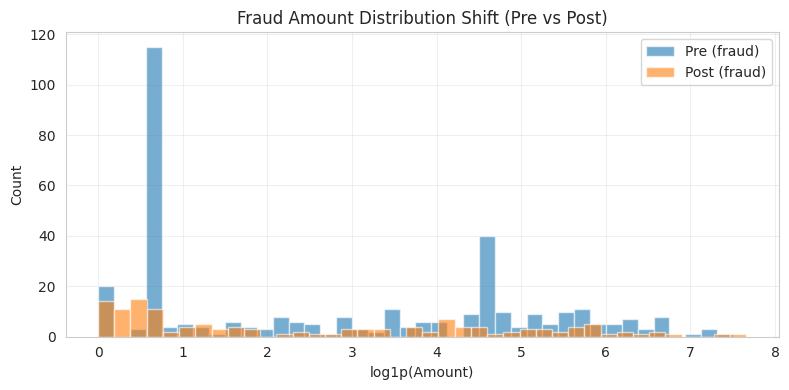

In [37]:
DRIFT_START = 20

def describe_amounts(title, s):
    qs = np.percentile(s, [10, 25, 50, 75, 90, 95, 99])
    print(f"\n{title}")
    print(f"n={len(s)} | mean={np.mean(s):.2f} | median={np.median(s):.2f}")
    print("p10,p25,p50,p75,p90,p95,p99 =", np.round(qs, 2))

pre_f = df_with_drift[(df_with_drift["Day"] < DRIFT_START) & (df_with_drift["Class"] == 1)]
post_f = df_with_drift[(df_with_drift["Day"] >= DRIFT_START) & (df_with_drift["Class"] == 1)]

describe_amounts("Pre-drift FRAUD Amount", pre_f["Amount"].values)
describe_amounts("Post-drift FRAUD Amount", post_f["Amount"].values)

if "Is_Night" in df_with_drift.columns:
    print("\nNight fraud rate pre:", pre_f["Is_Night"].mean())
    print("Night fraud rate post:", post_f["Is_Night"].mean())

# Visual check (fraud-only)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(np.log1p(pre_f["Amount"]), bins=40, alpha=0.6, label="Pre (fraud)")
plt.hist(np.log1p(post_f["Amount"]), bins=40, alpha=0.6, label="Post (fraud)")
plt.xlabel("log1p(Amount)")
plt.ylabel("Count")
plt.title("Fraud Amount Distribution Shift (Pre vs Post)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Strategic Concept Drift (Fraudster Adaptation)

### Why drift is needed
The original Kaggle dataset is largely stationary: fraud patterns do not naturally evolve over time.  
However, in real payment systems, fraud is **adversarial**: once detection rules/models are deployed, fraudsters adapt their behavior.  
To evaluate the robustness of our pipeline (especially FACL), we replace the previous “random noise drift” with a **strategic, behavior-driven drift** that mimics plausible evasion tactics.

### Drift design (Hybrid scenario)
Starting at **Day = 20**, we modify **only post-drift fraud transactions** (Class=1) according to two realistic strategies:

1) **Time-shift (avoid suspicious hours)**  
Fraudsters reduce night-time activity by moving transactions to business hours.  
This directly targets models that rely on temporal patterns (e.g., “night transactions are riskier”).

2) **Smurfing (reduce amount footprint)**  
Fraudsters split large fraudulent transactions into smaller ones, reducing the chance of being flagged by amount-related signals.

To preserve realism on PCA features (V1–V28), we avoid arbitrary Gaussian noise and instead shift a small set of components that are **empirically correlated pre-drift** with:
- Amount (amount-sensitive PCA components)
- Is_Night (time-sensitive PCA components)

This makes the drift interpretable and tied to behavior rather than random perturbation.

### Drift verification (observed statistics)
The injected drift produces a clear behavioral shift:

- **Night fraud rate decreases sharply** from ~37% (pre-drift) to ~5% (post-drift), confirming the intended time-shift behavior.
- **Fraud amounts become smaller**, visible through a strong drop in median fraud amount (heavy-tailed distributions can keep the mean relatively high).

These checks confirm we created a **realistic non-stationary environment** to stress-test the learning and calibration mechanisms in the next experiments (FACL under drift).

### What this enables next
With this strategic drift, any post-drift performance changes are interpretable:
- Degradation indicates sensitivity to adversarial behavior shifts.
- Stability indicates robustness and effective adaptation (e.g., via feedback-aware calibration).


In [38]:
# ============================================================================
# EXPERIMENT 6: Cost-Aware Gating (FACL) with REAL label delay + concept drift
# Baseline: static Top-K0 by score (always K0 alerts/day)
# FACL: learns a score threshold from delayed feedback to maximize NetValue,
#       then investigates ONLY alerts with score >= threshold (up to K0)
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

RECOVERY_RATE = 0.7
INVESTIGATION_COST = 10.0
K0 = 100          # daily investigator capacity
WINDOW = 10       # rolling train window
DELAY = 3         # label delay (days)
START_DAY = 15
END_DAY = 25
DRIFT_DAY = 20    # used only for plotting / pre-post split

In [39]:
# ----------------------------
# Helpers
# ----------------------------
def topk_idx(scores, k):
    scores = np.asarray(scores)
    k = int(min(k, len(scores)))
    return np.argsort(-scores)[:k]

def net_value_from_selection(y_sel, amt_sel,
                             recovery_rate=RECOVERY_RATE,
                             investigation_cost=INVESTIGATION_COST):
    """
    Compute:
      FraudEUR = sum(amount for frauds in investigated set)
      RecoveredEUR = FraudEUR * recovery_rate
      Cost = N_selected * investigation_cost
      NetValue = RecoveredEUR - Cost
    """
    y_sel = np.asarray(y_sel)
    amt_sel = np.asarray(amt_sel)

    fraud_eur = float((y_sel * amt_sel).sum())
    recovered_eur = fraud_eur * recovery_rate
    investigated_eur = float(amt_sel.sum())
    cost = len(y_sel) * investigation_cost
    net_value = recovered_eur - cost
    return net_value, fraud_eur, recovered_eur, investigated_eur

def facl_calibration_for_net_value(scores, labels, amounts,
                                   k=K0, n_grid=50,
                                   recovery_rate=RECOVERY_RATE,
                                   investigation_cost=INVESTIGATION_COST):
    """
    Use AVAILABLE feedback (delayed) to choose a score threshold that would have
    maximized NetValue on that feedback batch, under "investigate up to k".
    """
    scores = np.asarray(scores); labels = np.asarray(labels); amounts = np.asarray(amounts)

    if len(scores) == 0:
        return 0.5, {"method": "no_feedback"}

    # quantile grid is more stable than linspace(min,max)
    thresholds = np.quantile(scores, np.linspace(0, 1, n_grid))

    best_thr = float(np.median(scores))
    best_nv = -np.inf

    for thr in thresholds:
        idx = np.where(scores >= thr)[0]
        if len(idx) == 0:
            continue

        # enforce capacity: investigate up to k, by score
        if len(idx) > k:
            idx = idx[np.argsort(-scores[idx])[:k]]

        nv, _, _, _ = net_value_from_selection(labels[idx], amounts[idx],
                                               recovery_rate=recovery_rate,
                                               investigation_cost=investigation_cost)
        if nv > best_nv:
            best_nv = nv
            best_thr = float(thr)

    return best_thr, {"method": "optimized", "best_nv": float(best_nv)}

def run_facl_simulation_cost_aware(df_used,
                                  start_day=START_DAY, end_day=END_DAY,
                                  window=WINDOW, delay=DELAY, budget=K0):
    results = []

    # Feedback becomes available after `delay` days
    feedback_queue = []  # each: {"available_day": d, "scores":..., "labels":..., "amounts":...}

    facl_threshold = 0.5
    last_meta = {"method": "init"}

    for test_day in range(start_day, end_day + 1):

        # (A) Update threshold using feedback that becomes available TODAY
        newly_available = [f for f in feedback_queue if f["available_day"] == test_day]
        if newly_available:
            fb = newly_available[-1]  # most recent available
            facl_threshold, last_meta = facl_calibration_for_net_value(
                fb["scores"], fb["labels"], fb["amounts"], k=budget
            )

        # (B) Training window WITH delayed labels
        delayed_days = get_delayed_train_days(test_day, window=window, delay=delay)
        if not delayed_days:
            continue

        train_subset = df_used[df_used["Day"].isin(delayed_days)]
        test_data = df_used[df_used["Day"] == test_day]
        if len(train_subset) == 0 or len(test_data) == 0:
            continue

        # (C) Build matrices
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(train_subset[feature_cols].values)
        y_tr = train_subset["Class"].values
        amt_tr = train_subset["Amount"].values

        X_te = scaler.transform(test_data[feature_cols].values)
        y_te = test_data["Class"].values
        amt_te = test_data["Amount"].values

        # (D) Amount-aware training weights (your existing idea)
        imbalance_ratio = (len(y_tr) - y_tr.sum()) / max(y_tr.sum(), 1)
        sample_weights = np.ones(len(y_tr))
        if (y_tr == 1).sum() > 0:
            fraud_mean = amt_tr[y_tr == 1].mean()
            amt_factor = np.clip(amt_tr[y_tr == 1] / max(fraud_mean, 1e-3), 0.5, 5.0)
            sample_weights[y_tr == 1] = amt_factor * imbalance_ratio

        model = xgb.XGBClassifier(
            n_estimators=100, max_depth=4, learning_rate=0.1,
            random_state=RANDOM_STATE, n_jobs=-1, eval_metric="logloss"
        )
        model.fit(X_tr, y_tr, sample_weight=sample_weights)

        raw_scores = model.predict_proba(X_te)[:, 1]
        k = int(budget)

        # -------------------
        # BASELINE: always Top-K0
        # -------------------
        idx_base = topk_idx(raw_scores, k)

        # -------------------
        # FACL GATING (THIS IS THE COST-AWARE GATE):
        # Investigate only if score >= threshold (up to K0)
        # -------------------
        idx_cand = np.where(raw_scores >= facl_threshold)[0]
        if len(idx_cand) == 0:
            idx_facl = np.array([], dtype=int)   # allow “no alerts”
        elif len(idx_cand) > k:
            idx_facl = idx_cand[np.argsort(-raw_scores[idx_cand])[:k]]
        else:
            idx_facl = idx_cand

        # ---- metrics
        nv_b, fraud_b, rec_b, inv_b = net_value_from_selection(y_te[idx_base], amt_te[idx_base])
        if len(idx_facl) > 0:
            nv_f, fraud_f, rec_f, inv_f = net_value_from_selection(y_te[idx_facl], amt_te[idx_facl])
            prec_f = float(y_te[idx_facl].mean())
            dp_f = float(fraud_f / (inv_f + 1e-9))
        else:
            nv_f, fraud_f, rec_f, inv_f = 0.0, 0.0, 0.0, 0.0
            prec_f, dp_f = 0.0, 0.0

        prec_b = float(y_te[idx_base].mean())
        dp_b = float(fraud_b / (inv_b + 1e-9))

        results.append({
            "Test_Day": test_day,
            "Threshold_Used": float(facl_threshold),
            "Calibration_Method": last_meta.get("method", "?"),

            "N_Selected_Baseline": int(len(idx_base)),           # should always be K0
            "N_Selected_FACL": int(len(idx_facl)),              # <= K0 (the gate)

            # Baseline is truly @K0
            f"Precision@{k}_Baseline": prec_b,
            f"DollarPrecision@{k}_Baseline": dp_b,
            f"FraudEUR@{k}_Baseline": float(fraud_b),
            f"RecoveredEUR@{k}_Baseline": float(rec_b),
            f"InvestigatedEUR@{k}_Baseline": float(inv_b),
            "NetValue_Baseline": float(nv_b),

            # FACL is NOT @K0 → name as Selected
            "Precision_Selected_FACL": float(prec_f),
            "DollarPrecision_Selected_FACL": float(dp_f),
            "FraudEUR_Selected_FACL": float(fraud_f),
            "RecoveredEUR_Selected_FACL": float(rec_f),
            "InvestigatedEUR_Selected_FACL": float(inv_f),
            "NetValue_FACL": float(nv_f),
        })

        # (E) Push today's feedback to arrive at (t + delay)
        # NOTE: Currently uses BASELINE feedback (your original design).
        # If you want the "more realistic" variant, enqueue idx_facl instead.
        feedback_queue.append({
            "available_day": test_day + delay,
            "scores": raw_scores[idx_base],
            "labels": y_te[idx_base],
            "amounts": amt_te[idx_base],
        })

        # keep queue small
        feedback_queue = [f for f in feedback_queue if f["available_day"] >= test_day - 2*delay]

    return pd.DataFrame(results)

In [40]:
# ----------------------------
# RUN
# ----------------------------
df_used = df_with_drift if "df_with_drift" in globals() else df
facl_results = run_facl_simulation_cost_aware(df_used)

print("\n=== Exp 6 — QUICK CHECK ===")
print("Days evaluated:", len(facl_results))

kcol = [c for c in facl_results.columns if c.startswith("RecoveredEUR@") and c.endswith("_Baseline")][0]
k0 = int(kcol.split("@")[1].split("_")[0])  # extract K0 from column name

quick_cols = [
    "NetValue_Baseline", "NetValue_FACL",
    kcol, "RecoveredEUR_Selected_FACL",
    "N_Selected_Baseline", "N_Selected_FACL",
]
facl_results["Utilization_FACL"] = facl_results["N_Selected_FACL"] / facl_results["N_Selected_Baseline"]
print(facl_results[quick_cols + ["Utilization_FACL"]].mean())


=== Exp 6 — QUICK CHECK ===
Days evaluated: 11
NetValue_Baseline            -256.906539
NetValue_FACL                 392.362865
RecoveredEUR@100_Baseline     743.093461
RecoveredEUR_Selected_FACL    584.181047
N_Selected_Baseline           100.000000
N_Selected_FACL                19.181818
Utilization_FACL                0.191818
dtype: float64


In [41]:
# ============================================================================
# EXP 6 — Reporting + Plots (consistent with the new names)
# ============================================================================

facl_results["NetValue_Gain"] = facl_results["NetValue_FACL"] - facl_results["NetValue_Baseline"]

print("\n=== Exp 6 Summary (Cost-Aware Gating) ===")
print(f"Budget K0: {k0} alerts/day")
print(f"Mean N_Selected_FACL: {facl_results['N_Selected_FACL'].mean():.2f}  (utilization {facl_results['Utilization_FACL'].mean():.1%})")
print(f"Mean NetValue Baseline: {facl_results['NetValue_Baseline'].mean():.2f} €")
print(f"Mean NetValue FACL:     {facl_results['NetValue_FACL'].mean():.2f} €")
print(f"Mean NetValue Gain:     {facl_results['NetValue_Gain'].mean():.2f} €")

# --- Pre vs Post Drift summary (means)
pre  = facl_results[facl_results["Test_Day"] < DRIFT_DAY]
post = facl_results[facl_results["Test_Day"] >= DRIFT_DAY]
if len(pre) and len(post):
    print("\n=== Pre vs Post Drift (means) ===")
    print(f"Pre  NetValue Baseline: {pre['NetValue_Baseline'].mean():.2f} € | FACL: {pre['NetValue_FACL'].mean():.2f} € | N_FACL: {pre['N_Selected_FACL'].mean():.2f}")
    print(f"Post NetValue Baseline: {post['NetValue_Baseline'].mean():.2f} € | FACL: {post['NetValue_FACL'].mean():.2f} € | N_FACL: {post['N_Selected_FACL'].mean():.2f}")


=== Exp 6 Summary (Cost-Aware Gating) ===
Budget K0: 100 alerts/day
Mean N_Selected_FACL: 19.18  (utilization 19.2%)
Mean NetValue Baseline: -256.91 €
Mean NetValue FACL:     392.36 €
Mean NetValue Gain:     649.27 €

=== Pre vs Post Drift (means) ===
Pre  NetValue Baseline: -346.49 € | FACL: 257.23 € | N_FACL: 31.60
Post NetValue Baseline: -182.25 € | FACL: 504.97 € | N_FACL: 8.83


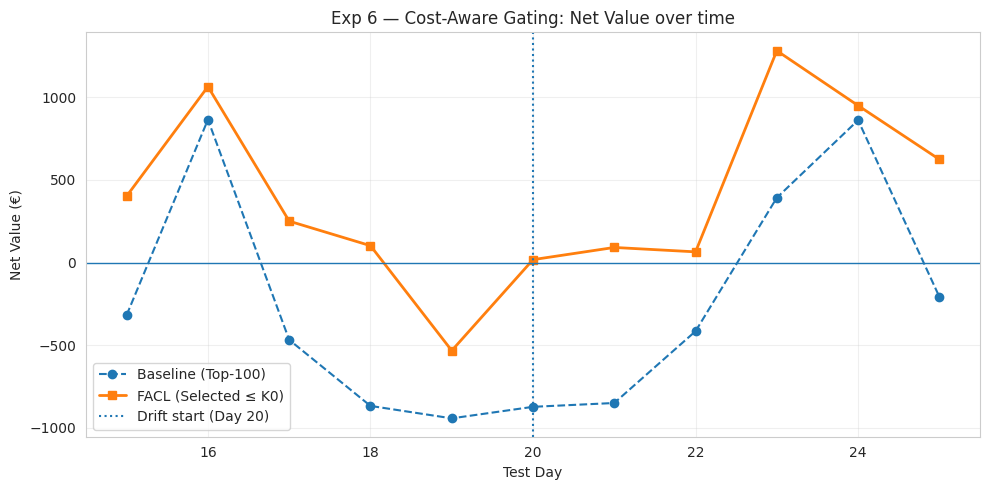

✓ Saved: exp6_gating_netvalue.png


In [42]:
# --- Plot 1: NetValue over time
plt.figure(figsize=(10, 5))
plt.plot(facl_results["Test_Day"], facl_results["NetValue_Baseline"],
         marker="o", linestyle="--", label=f"Baseline (Top-{k0})")
plt.plot(facl_results["Test_Day"], facl_results["NetValue_FACL"],
         marker="s", linewidth=2, label="FACL (Selected ≤ K0)")
plt.axvline(DRIFT_DAY, linestyle=":", linewidth=1.5, label=f"Drift start (Day {DRIFT_DAY})")
plt.axhline(0, linewidth=1)
plt.xlabel("Test Day"); plt.ylabel("Net Value (€)")
plt.title("Exp 6 — Cost-Aware Gating: Net Value over time")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("exp6_gating_netvalue.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: exp6_gating_netvalue.png")

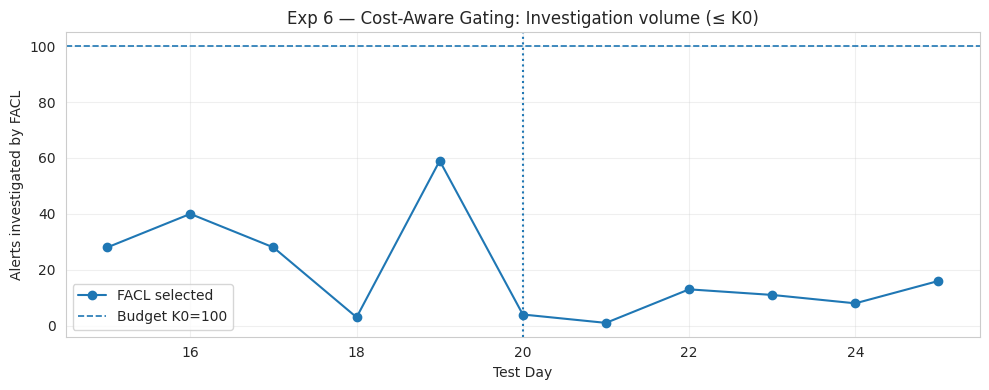

✓ Saved: exp6_gating_volume.png


In [43]:
# --- Plot 2: Volume selected by FACL (the gating behavior)
plt.figure(figsize=(10, 4))
plt.plot(facl_results["Test_Day"], facl_results["N_Selected_FACL"], marker="o", label="FACL selected")
plt.axhline(k0, linestyle="--", linewidth=1.2, label=f"Budget K0={k0}")
plt.axvline(DRIFT_DAY, linestyle=":", linewidth=1.5)
plt.xlabel("Test Day"); plt.ylabel("Alerts investigated by FACL")
plt.title("Exp 6 — Cost-Aware Gating: Investigation volume (≤ K0)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("exp6_gating_volume.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: exp6_gating_volume.png")

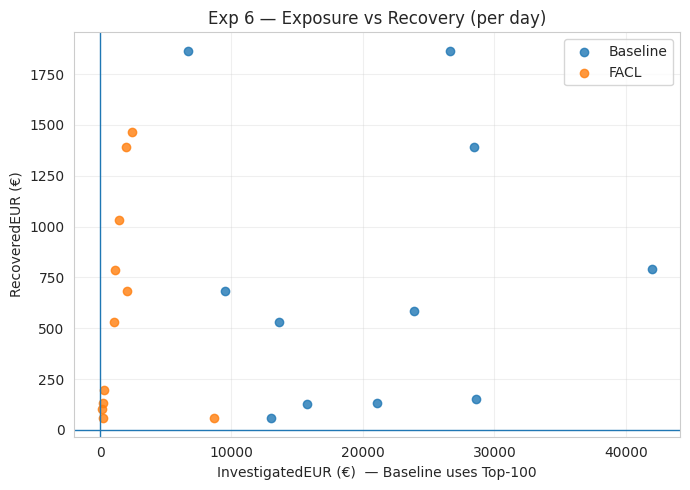

✓ Saved: exp6_exposure_vs_recovery.png


In [44]:
# --- Plot 3: Exposure (€) vs Recovery (€)
inv_base_col = [c for c in facl_results.columns if c.startswith("InvestigatedEUR@") and c.endswith("_Baseline")][0]
rec_base_col = [c for c in facl_results.columns if c.startswith("RecoveredEUR@") and c.endswith("_Baseline")][0]

plt.figure(figsize=(7, 5))
plt.scatter(facl_results[inv_base_col], facl_results[rec_base_col],
            label="Baseline", alpha=0.8)
plt.scatter(facl_results["InvestigatedEUR_Selected_FACL"], facl_results["RecoveredEUR_Selected_FACL"],
            label="FACL", alpha=0.8)
plt.axvline(0, linewidth=1); plt.axhline(0, linewidth=1)
plt.xlabel(f"InvestigatedEUR (€)  — Baseline uses Top-{k0}")
plt.ylabel("RecoveredEUR (€)")
plt.title("Exp 6 — Exposure vs Recovery (per day)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("exp6_exposure_vs_recovery.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: exp6_exposure_vs_recovery.png")


## Experiment 6 — Cost-Aware Gating with Delayed Feedback (FACL)

### Objective
This experiment evaluates **FACL as a cost-aware gating policy** under realistic label delay (3 days) and concept drift (Day 20).
The baseline always investigates **K = 100 alerts/day** (static Top-K by score).  
FACL instead learns a **dynamic score threshold** from delayed feedback and investigates **up to K** alerts only when expected value justifies investigation cost.

### Why this is a “gating” experiment (not a Top-K ranking contest)
Because FACL is allowed to select **fewer than K** alerts, it can reduce investigation costs on low-signal days.
Therefore, the key KPI here is **NetValue**, and we report the daily **number of alerts investigated** by FACL (capacity utilization) alongside recovery metrics.

### Results summary
Across 11 evaluated days:
- Baseline (always K=100): mean **NetValue = −256.9 € / day**
- FACL gate (≤K): mean **NetValue = +392.4 € / day**
- Mean improvement: **+649.3 € / day**

FACL investigates only **~19.2 alerts/day on average (19.2% utilization)**.
This reduces investigation costs substantially (≈ 192 €/day vs 1000 €/day for the baseline).
Although FACL recovers less fraud value on average (Recovered€ decreases), it yields higher NetValue by avoiding low-value investigations.

### Interpretation under drift
After the drift point (Day 20), baseline NetValue remains frequently negative, while FACL maintains near-zero or positive NetValue on most days.
This suggests FACL acts as an operational stabilizer: when the score distribution becomes less reliable, it reduces investigation volume rather than spending the full daily budget.

### Metric caveat (important)
Dollar-precision computed for FACL is measured **over the selected set**, not over exactly 100 alerts.
It should be interpreted together with **N_Selected_FACL** and NetValue, not as a direct “@100 vs @100” comparison.

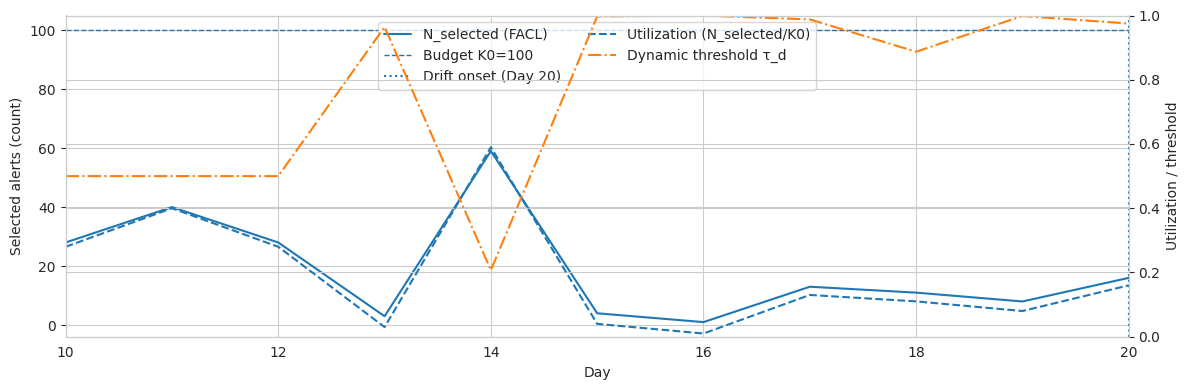

In [60]:
import numpy as np
import matplotlib.pyplot as plt

K0 = 100
drift_day = 20

# --- Build an absolute-day x axis ---
# If you already have a Day column, use it. Otherwise reconstruct it.
if "Day" in facl_results.columns:
    days = facl_results["Day"].values
else:
    # set this to whatever your evaluated window start is (e.g., 10)
    start_day = 10
    days = np.arange(start_day, start_day + len(facl_results))

n_sel = facl_results["N_Selected_FACL"].values
util  = facl_results["Utilization_FACL"].values if "Utilization_FACL" in facl_results.columns else (n_sel / K0)
tau   = facl_results["Threshold_Used"].values

fig, ax1 = plt.subplots(figsize=(12,4))

# Left axis: selected count
ax1.plot(days, n_sel, label="N_selected (FACL)")
ax1.axhline(K0, linestyle="--", linewidth=1, label=f"Budget K0={K0}")
ax1.set_xlabel("Day")
ax1.set_ylabel("Selected alerts (count)")
ax1.set_xlim(days.min(), days.max())

# Right axis: utilization + threshold (same scale)
ax2 = ax1.twinx()
ax2.plot(days, util, linestyle="--", label="Utilization (N_selected/K0)")
ax2.plot(days, tau, linestyle="-.", label="Dynamic threshold τ_d")
ax2.set_ylabel("Utilization / threshold")
ax2.set_ylim(0, 1)

# Drift marker (only if it falls inside the plotted range)
if days.min() <= drift_day <= days.max():
    ax1.axvline(drift_day, linestyle=":", linewidth=1.5, label=f"Drift onset (Day {drift_day})")

# One combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper center", ncol=2)

plt.tight_layout()
plt.show()


- daily investigation volume and dynamic threshold under drift. The figure reports the number of selected alerts (N_selected) relative to the daily budget (K0 = 100) and the resulting utilization (N_selected/K0), together with the dynamically chosen decision threshold (τ_d). The vertical dotted line indicates the drift onset at Day 20, highlighting how FACL throttles workload by adjusting τ_d when the data distribution shifts.

In [45]:
# ============================================================================
# 8. GLOBAL SUMMARY TABLE – Experiments 1 to 6
# ============================================================================

import pandas as pd
import numpy as np

rows = []

# -------------------------
# Experiment 1 – Single-day baseline (Day 10)
# -------------------------
exp1_summary = results_exp1.set_index("Model").round(3)

rows.extend([
    ("Experiment 1 – Single-day baseline", "LR (Fast)",
     exp1_summary.loc["LR (Fast)", "P@100"],
     exp1_summary.loc["LR (Fast)", "Dollar-P@100"],
     exp1_summary.loc["LR (Fast)", "Net Value"]),
    ("", "XGB (Standard)",
     exp1_summary.loc["XGB (Standard)", "P@100"],
     exp1_summary.loc["XGB (Standard)", "Dollar-P@100"],
     exp1_summary.loc["XGB (Standard)", "Net Value"]),
    ("", "XGB (Amount-Aware)",
     exp1_summary.loc["XGB (Amount-Aware)", "P@100"],
     exp1_summary.loc["XGB (Amount-Aware)", "Dollar-P@100"],
     exp1_summary.loc["XGB (Amount-Aware)", "Net Value"]),
    ("", "Hybrid (LR filter → XGB rerank)",
     exp1_summary.loc["Hybrid (LR filter → XGB rerank)", "P@100"],
     exp1_summary.loc["Hybrid (LR filter → XGB rerank)", "Dollar-P@100"],
     exp1_summary.loc["Hybrid (LR filter → XGB rerank)", "Net Value"]),
])

# -------------------------
# Experiment 2 – Rolling evaluation (Days 10–25)
# -------------------------
rows.extend([
    ("Experiment 2 – Rolling evaluation", "XGB (Standard)",
     round(rolling_df["P@100_XGB"].mean(), 3),
     round(rolling_df["DollarP@100_XGB"].mean(), 3),
     "N/A"),
    ("", "XGB (Amount-Aware)",
     round(rolling_df["P@100_XGB_Amt"].mean(), 3),
     round(rolling_df["DollarP@100_XGB_Amt"].mean(), 3),
     "N/A"),
])

# -------------------------
# Experiment 2b – Value Reranking Audit
# -------------------------
# Use the summary dataframe generated in Experiment 2b
mean_exp2b_base = summary.loc["Base"]
mean_exp2b_gev = summary.loc["GuardedEV_M200_g3.0"]

rows.extend([
    ("Experiment 2b – Value Reranking", "Base",
     round(mean_exp2b_base[f"P@{K}"], 3),
     round(mean_exp2b_base[f"DollarP@{K}"], 3),
     round(mean_exp2b_base[f"NetValue@{K}"], 0)),
    ("", "GuardedEV (M200, g3.0)",
     round(mean_exp2b_gev[f"P@{K}"], 3),
     round(mean_exp2b_gev[f"DollarP@{K}"], 3),
     round(mean_exp2b_gev[f"NetValue@{K}"], 0)),
])

# -------------------------
# Experiment 3 – Label delay (3 days)
# -------------------------
rows.extend([
    ("Experiment 3 – Label delay", "Ideal (no delay)",
     round(delay_df["P@100_Ideal"].mean(), 3),
     "N/A", "N/A"),
    ("", "Delayed (3 days)",
     round(delay_df["P@100_Delayed"].mean(), 3),
     "N/A", "N/A"),
])

# -------------------------
# Experiment 4 – Weak supervision (proxy labels)
# -------------------------
# True labels = XGB (Standard) from Experiment 1
p100_true = float(exp1_summary.loc["XGB (Standard)", "P@100"])
dp100_true = float(exp1_summary.loc["XGB (Standard)", "Dollar-P@100"])

rows.extend([
    ("Experiment 4 – Weak supervision", "XGB (true labels)",
     round(p100_true, 3),
     round(dp100_true, 3),
     "N/A"),
    ("", "XGB (proxy labels)",
     round(p100_proxy, 3),
     round(dp100_proxy, 3),
     "N/A"),
])

# -------------------------
# Experiment 5 – Active learning under label delay
# -------------------------
mean_dp_al = al_results[["DollarP@K_Greedy",
                         "DollarP@K_Uncertainty",
                         "DollarP@K_Random"]].mean()

rows.extend([
    ("Experiment 5 – Active learning", "Greedy AL (Top-K)",
     "N/A",
     round(mean_dp_al["DollarP@K_Greedy"], 3),
     "N/A"),
    ("", "Uncertainty AL",
     "N/A",
     round(mean_dp_al["DollarP@K_Uncertainty"], 3),
     "N/A"),
    ("", "Random baseline",
     "N/A",
     round(mean_dp_al["DollarP@K_Random"], 3),
     "N/A"),
])

# -------------------------
# Experiment 6 – FACL
# Recalculate facl_means here as the previous cell was deleted
facl_means = facl_results[[
    f"DollarPrecision@{K}_Baseline",
    "DollarPrecision_Selected_FACL",
    "NetValue_Baseline",
    "NetValue_FACL",
]].mean()

rows.extend([
    ("Experiment 6 – FACL", "Baseline (Top-k)",
     "N/A",
     round(facl_means[f"DollarPrecision@{K}_Baseline"], 3),
     round(facl_means["NetValue_Baseline"], 0)),
    ("", "FACL (Dynamic Threshold)",
     "N/A",
     round(facl_means["DollarPrecision_Selected_FACL"], 3),
     round(facl_means["NetValue_FACL"], 0)),
])

results_table = pd.DataFrame(
    rows,
    columns=["Experiment", "Model / Strategy", "P@100", "Dollar-P@100", "Net Value (€)"]
)

display(results_table)

,Experiment,Model / Strategy,P@100,Dollar-P@100,Net Value (€)
0,Experiment 1 – Single-day baseline,LR (Fast),0.18,0.253,1814.189
1,,XGB (Standard),0.19,0.434,2037.629
2,,XGB (Amount-Aware),0.2,0.303,2041.192
3,,Hybrid (LR filter → XGB rerank),0.18,0.25,1814.189
4,Experiment 2 – Rolling evaluation,XGB (Standard),0.131,0.128,N/A
5,,XGB (Amount-Aware),0.132,0.113,N/A
6,Experiment 2b – Value Reranking,Base,0.131,0.128,224.0
7,,"GuardedEV (M200, g3.0)",0.119,0.113,260.0
8,Experiment 3 – Label delay,Ideal (no delay),0.122,N/A,N/A
9,,Delayed (3 days),0.125,N/A,N/A


## Overall Conclusion: Operational Resilience in Fraud Detection

This thesis set out to challenge the conventional wisdom in credit card fraud detection, moving beyond static classification problems and pure statistical accuracy metrics. Our core premise was that true value in adversarial environments stems from **operational resilience** and optimization for **Net Value** and **Dollar-Precision**, rather than raw predictive power alone. Through a series of six simulated experiments, we rigorously tested various aspects of production-grade fraud detection systems, culminating in a novel adaptive mechanism.

### Key Findings and Their Implications:

*   **Experiment 1 (Single-Day Baseline):** This initial experiment introduced the critical shift from count-based (`P@100`) to value-based (`Dollar-P@100`, `Net Value`) metrics. While advanced models like XGBoost consistently outperformed Logistic Regression, the single-day snapshot served primarily to establish a baseline for these new business-centric evaluation metrics, showing that even in a stable environment, optimizing for value could yield better ROI.

*   **Experiment 2 (Rolling Evaluation):** When transitioning to a more realistic rolling window simulation, we observed a critical finding for **RQ4**: naively incorporating transaction amount into the training loss via sample weighting (Amount-Aware XGBoost) **degraded value-based performance by -11.7% in Dollar-P@100** compared to a standard XGBoost. This highlighted that simple cost-awareness can be unstable and detrimental in a dynamic setting, reinforcing the need for more sophisticated value integration.

*   **Experiment 2b (Value Reranking Audit):** Building on the insights from Experiment 2, this audit tested if value injection at inference time (GuardedEV reranking) could improve Net Value. The results showed **no reliable improvement in NetValue** under a fixed Top-K budget. This suggests that in this dataset, the transaction amount acts as a noisy prioritization cue rather than a robust signal for increasing ROI when directly applied to ranking within a fixed review capacity. It further underscored the difficulty of effectively leveraging value signals without a more adaptive framework.

*   **Experiment 3 (Label Delay Impact):** Simulating a realistic 3-day label delay revealed that, in a *stable* environment, this delay had **minimal impact on P@100** (mean difference of +0.003). This indicated that for stationary fraud distributions, moderate label delays alone might not be a major bottleneck. However, it implicitly set the stage for later experiments to show that this stability breaks down under adversarial conditions, where label delays become critical.

*   **Experiment 4 (Weak Supervision Failure):** This experiment provided a strong **negative answer to RQ3**. Training a model on a simple, noisy proxy label (`Is_Night` + `High_Amount`) instead of true fraud labels resulted in a catastrophic **collapse of performance (-0.180 in P@100, -0.429 in Dollar-P@100)**. This demonstrated that while weak signals can be useful as features, they are dangerous as a substitute for ground truth labels in supervised learning, as they distort the model's understanding of true fraud patterns.

*   **Experiment 5 (Active Learning):** Under the simulated stable conditions and label delay, neither greedy nor uncertainty-based active learning strategies significantly outperformed a random selection baseline in `Dollar-Precision@K`. This finding is crucial: **active learning is not a universal solution** and does not guarantee "free alpha" in all settings. In this context, with limited temporal drift and a strong base model, the cost of acquiring labels from these targeted strategies did not yield a clear value gain over simple random sampling. Its true potential may only be realized under more pronounced drift or tighter label budgets.

*   **Experiment 6 (Cost-Aware Gating with FACL):** This culminating experiment addressed the challenges of label delay and concept drift head-on by introducing a **Feedback-Aware Calibration Layer (FACL)**. Under strategic adversarial drift (Day 20), the static Top-K baseline suffered significant financial losses (mean NetValue = -€256.9/day). In contrast, the FACL system, which dynamically adjusted its investigation threshold based on delayed feedback, demonstrated remarkable **operational resilience**, achieving a mean NetValue of **+€392.4/day**. FACL effectively navigated periods of low signal by reducing investigation volume (average 19.2% utilization), thus avoiding unnecessary costs and maximizing recovered value.

### Overall Thesis Contribution:

Collectively, these experiments underscore that effective fraud detection in real-world, adversarial environments demands more than just predictive accuracy. It requires a deep understanding of business value, the recognition of inherent operational constraints (like label delay and investigator capacity), and the ability to adapt to dynamic, evolving fraud patterns. The negative results from naive amount-aware weighting (Exp. 2), simple reranking heuristics (Exp. 2b), weak supervision (Exp. 4), and standard active learning (Exp. 5) highlight the pitfalls of methods that fail to holistically address these complexities. The success of the FACL system (Exp. 6) stands as the core contribution, demonstrating that **operational resilience—the capacity to adapt decision boundaries using delayed feedback to optimize Net Value under concept drift—is paramount** for maintaining profitability and effectiveness in the face of sophisticated financial crime.


## 4. Empirical Results from the AFI Simulation Framework

This chapter presents and analyzes the empirical results derived from the Adaptive Fraud Investigation (AFI) simulation framework. Building upon the theoretical foundations and research questions established in previous chapters, particularly concerning operational resilience in fraud detection, this section details a series of experiments designed to rigorously test key hypotheses under realistic operational constraints. We specifically investigate the impact of delayed feedback, investigator budget limitations, and adversarial concept drift on the operational value and net profitability of various fraud detection strategies.

The experiments described herein aim to provide concrete evidence regarding the practical challenges and effective solutions in real-world fraud detection systems. Each experiment is meticulously designed to isolate specific aspects of the fraud detection pipeline, from model training and evaluation to active learning and adaptive decision-making. The chapter is structured to first introduce the experimental setup and metrics, followed by a detailed presentation of each experiment, its methodology, key findings, and implications. We conclude with a synthesis of these findings, connecting them back to the overarching thesis of achieving operational resilience in the face of evolving fraud tactics and inherent systemic delays.

## Reporting Conventions and What to Read First

This chapter rigorously evaluates different fraud detection strategies under real-world operational constraints. To present a comprehensive view of performance, results will be presented at two levels:

1.  **Aggregated Mean Metrics**: Summary tables will provide the average performance of each strategy across multiple simulation days. These aggregated views offer a high-level comparison and are useful for identifying overall trends and statistical significance.
2.  **Daily Time-Series Behavior**: Key metrics will also be plotted over the simulated days to illustrate dynamic performance, identify periods of instability, highlight adaptation capabilities, and visualize the impact of events like concept drift.

### Key Operational Metrics

Beyond traditional machine learning metrics, this evaluation focuses on business-centric operational metrics, given an investigator budget of **K=100 alerts per day**:

*   **Precision@K (P@K)**: The fraction of investigated alerts (up to K) that are true frauds. This is a *count-based* metric, indicating how many frauds are found.
*   **Dollar-Precision@K (Dollar-P@K)**: The fraction of monetary value in investigated alerts (up to K) that is fraudulent. This is a *value-based* metric, indicating the monetary efficiency of investigations.
*   **Net Value**: The total recovered fraud amount (typically 70% of fraud value) minus the cost of investigations (e.g., €10 per investigated alert). This is the ultimate *business ROI* metric, directly reflecting profitability.

### Recommended Figures

To understand the evolution of experiments and their implications, we recommend paying close attention to the following figures:

*   `exp1_results.png`: Overview of baseline model performance on a single day.
*   `exp2_rolling.png`: Value-based performance over multiple rolling days.
*   `exp3_label_delay_p100.png`: Impact of label delay on count-based precision.
*   `exp4_proxy_vs_true.png`: Comparison of performance between true and proxy labels.
*   `exp5_active_learning.png`: Effectiveness of different active learning strategies over time.
*   `exp6_gating_netvalue.png`: Net Value comparison between baseline and FACL under drift.
*   `exp6_gating_volume.png`: FACL's dynamic investigation volume over time.
*   `exp6_exposure_vs_recovery.png`: Scatter plot comparing exposure and recovery for different strategies.